# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
#{} But have three times as much base likelihood of buying something

users = []
 
for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=41.27701077659211, mobile=True), User(purchased=False, time_on_site=151.6783723328601, mobile=True), User(purchased=True, time_on_site=396.90790269620754, mobile=False), User(purchased=True, time_on_site=37.71180727737666, mobile=True), User(purchased=False, time_on_site=99.58878903756637, mobile=True), User(purchased=False, time_on_site=143.88613688378462, mobile=False), User(purchased=False, time_on_site=162.86138144128861, mobile=True), User(purchased=True, time_on_site=71.70588251762705, mobile=True), User(purchased=False, time_on_site=58.557409298278884, mobile=True), User(purchased=False, time_on_site=267.50036847362287, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,41.277011,True
1,False,151.678372,True
2,True,396.907903,False
3,True,37.711807,True
4,False,99.588789,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.89303850484635,6.02586164517321,6.695066016099188,7.067356984767261,7.490912552910866,8.066641268107086,8.379076904444311,9.237868996579252,9.275883815986703,9.463711631313032,9.560229373844571,9.577705719269595,10.041106428109753,10.4019070760911,10.48989173349638,10.784104403631838,11.634625173762942,11.725764318628002,12.047569585814722,12.24514550631714,12.61462315665302,13.036473465105637,13.138815558354883,13.635398767827585,13.718881820298725,14.433538237384374,14.458548880706168,14.484652605374688,15.009107687560084,15.384538142601187,15.75161298371212,16.012133033408666,16.190207564609985,17.552602162503504,17.753699473038772,17.887034353025367,17.910717550756257,18.139590237932886,18.282881728866595,18.2868128200264,...,482.4047151195504,484.0332274643393,485.39833570298134,491.82843160636986,496.33532159944684,502.60047785347325,505.6050469989217,509.7846227840599,516.8015823030707,522.8775763819473,523.1569922577899,523.45626811439,523.4703017512209,524.4286173485299,525.0402989096742,527.977047159788,528.592446670548,529.7655605147779,531.5631790560728,532.3451735277573,534.0422079121525,539.2387310078434,541.845918781228,542.9315720931115,543.4092942704873,543.8141615149519,544.4750169851119,545.6399888782199,547.4596818254154,556.7515025555047,558.151290994021,562.9618774310223,574.2304979041544,585.5016719666954,586.3876716469183,589.1516773097468,591.3882539113878,592.6137625048858,595.0218536896235,598.4886153991752
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,...,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1
True,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,1,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

TypeError: ignored

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/azbowler32/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv")
print(df.shape)
df.head()

(1200, 4)


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
# Cleaning column names and adding units
df = df.rename(index=str, columns={"Unnamed: 0":"unique ID","weight": "weight_(lbs)", "exercise_time": "exercise_time_(min/wk)", "age": "age_(years)"})
df.head()

,unique ID,age_(years),weight_(lbs),exercise_time_(min/wk),exercise_time_(min/day)
0,0,44,118,192,3.200000
1,1,41,161,35,0.583333
2,2,46,128,220,3.666667
3,3,39,216,57,0.950000
4,4,28,116,182,3.033333


In [0]:
# Adding a min/day column.
df["exercise_time_(min/day)"] = df["exercise_time_(min/wk)"] / 60
df.head()

,unique ID,age_(years),weight_(lbs),exercise_time_(min/wk),exercise_time_(min/day)
0,0,44,118,192,3.200000
1,1,41,161,35,0.583333
2,2,46,128,220,3.666667
3,3,39,216,57,0.950000
4,4,28,116,182,3.033333


In [0]:
# Checking to see if there are any missing values
df.isna().sum()

unique ID                  0
age_(years)                0
weight_(lbs)               0
exercise_time_(min/wk)     0
exercise_time_(min/day)    0
dtype: int64

In [0]:
# Finding the key stats of each column.
df.describe()

,unique ID,age_(years),weight_(lbs),exercise_time_(min/wk),exercise_time_(min/day)
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833,2.248514
std,346.554469,18.166802,35.132182,85.548895,1.425815
min,0.000000,18.000000,100.000000,0.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000,1.083333
50%,599.500000,48.000000,149.000000,122.000000,2.033333
75%,899.250000,64.000000,180.250000,206.000000,3.433333
max,1199.000000,80.000000,246.000000,300.000000,5.000000


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


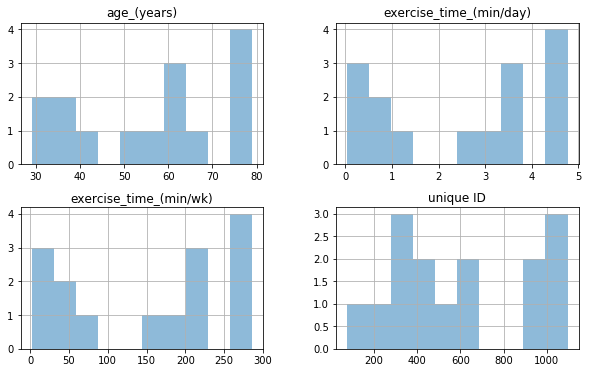

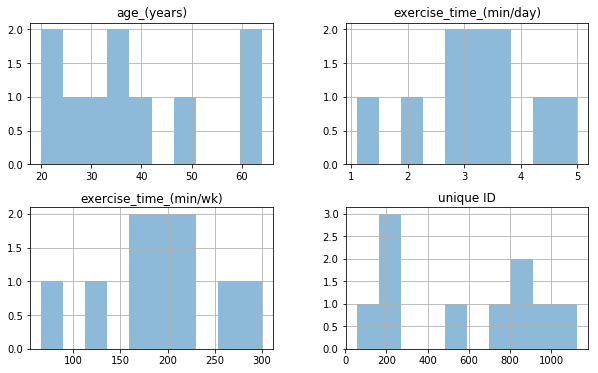

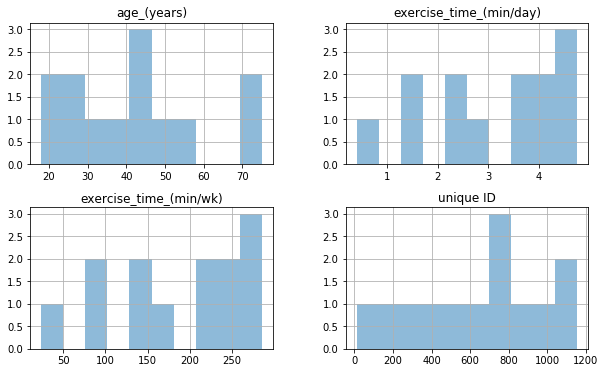

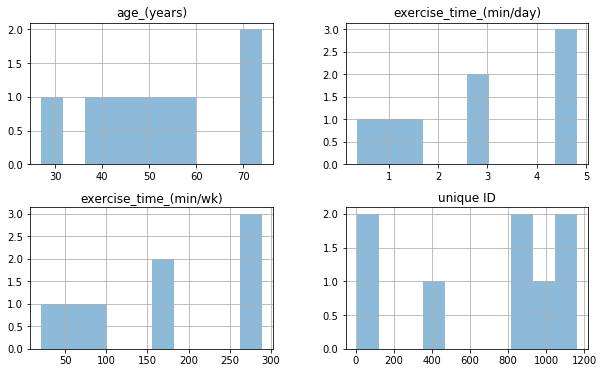

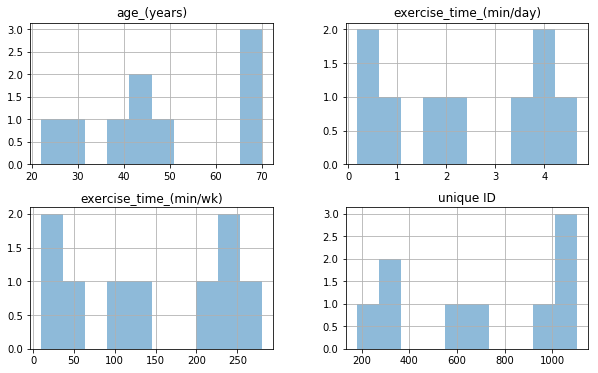

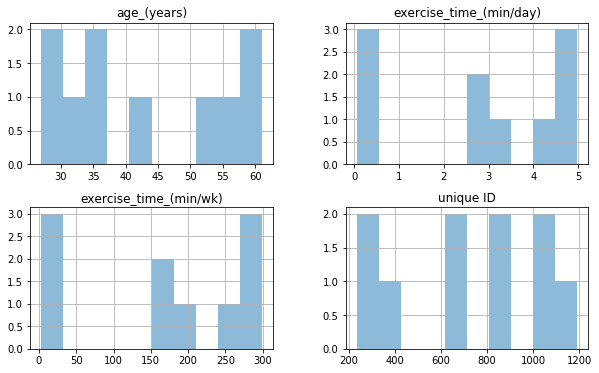

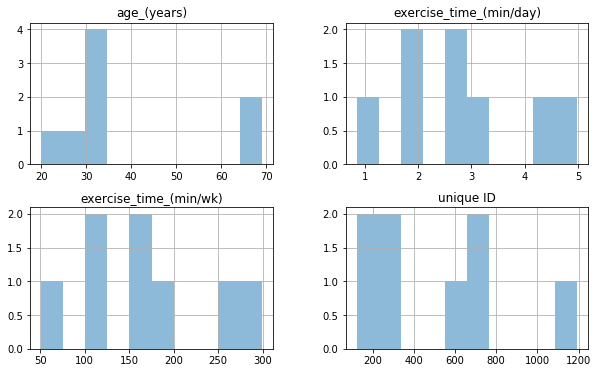

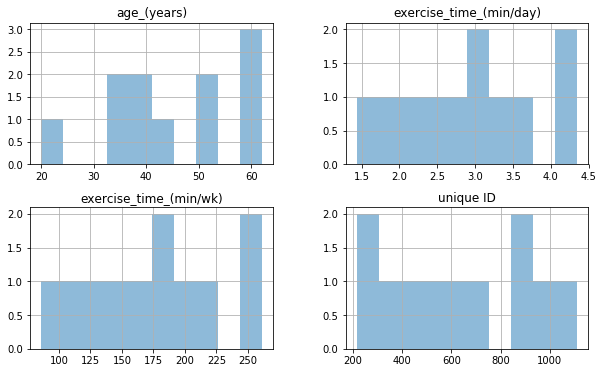

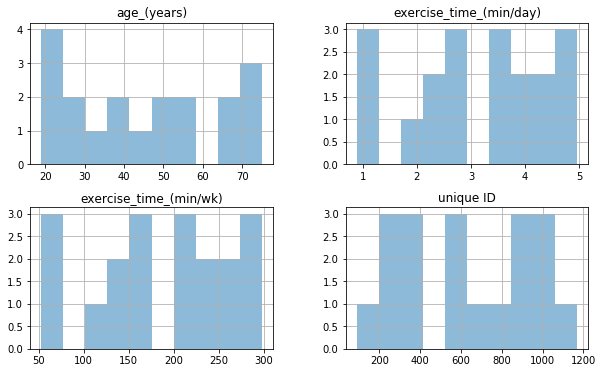

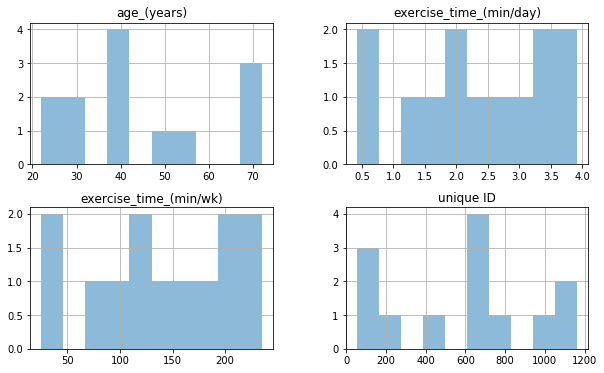

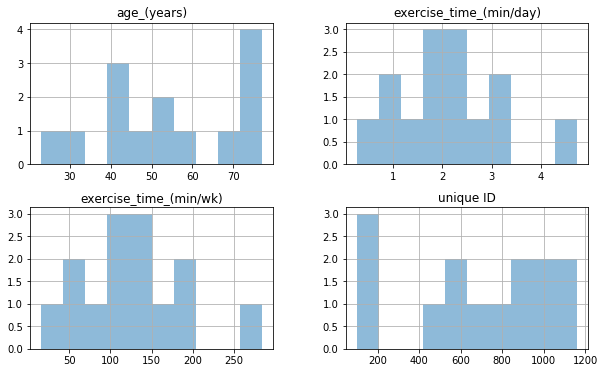

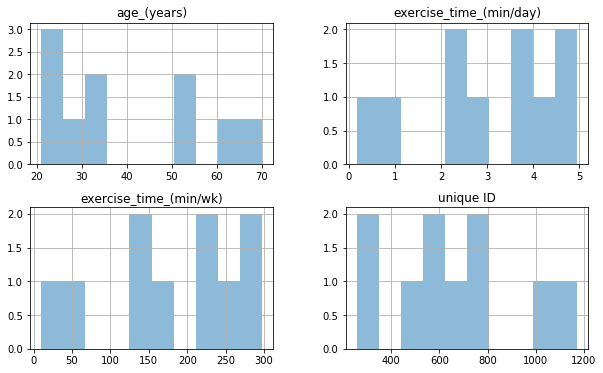

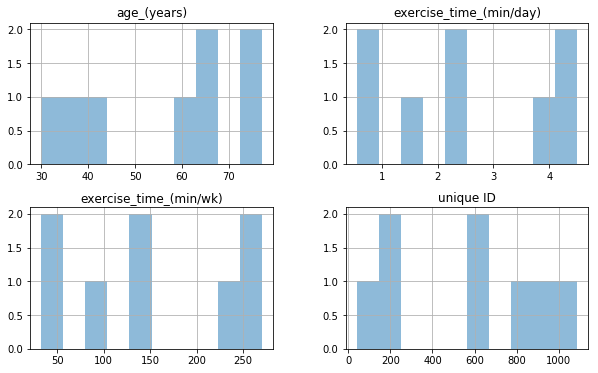

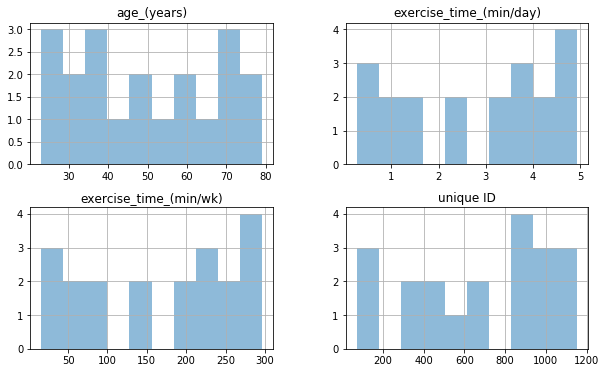

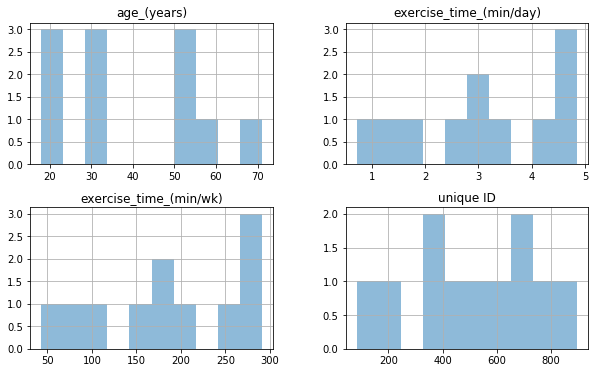

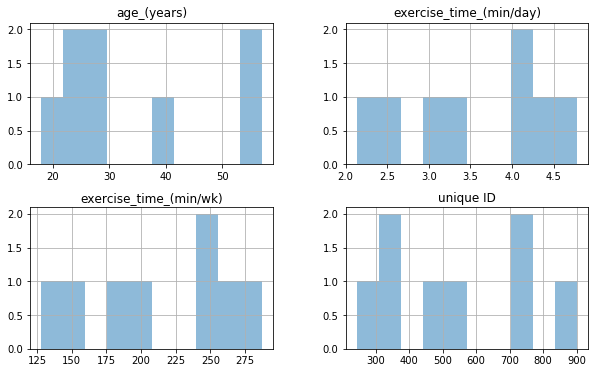

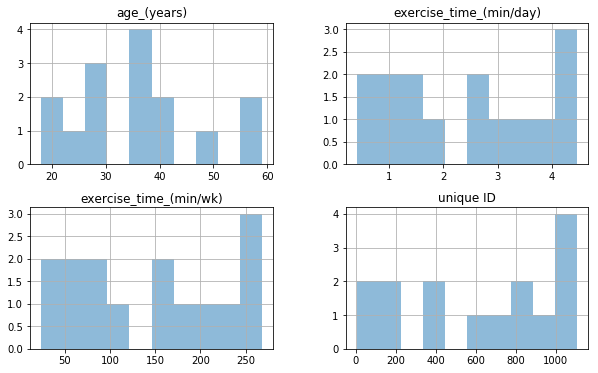

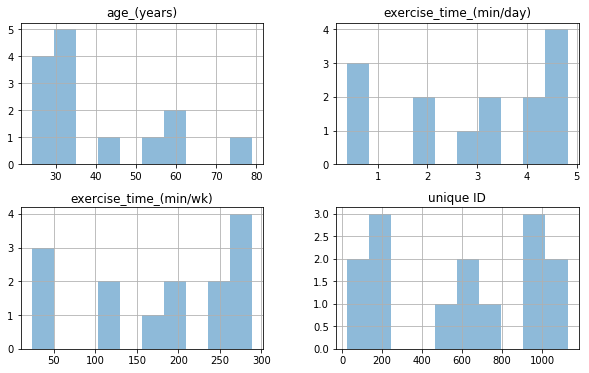

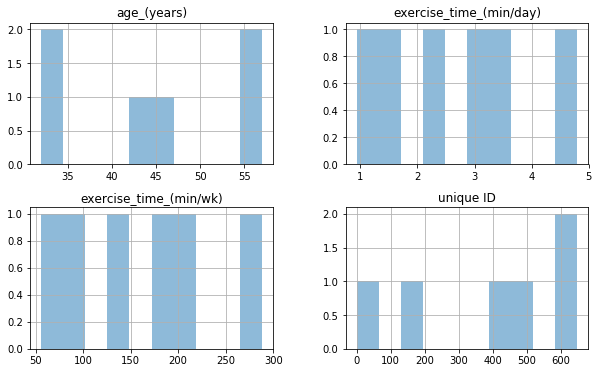

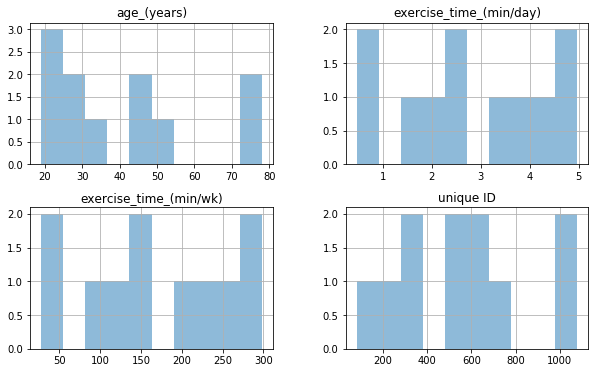

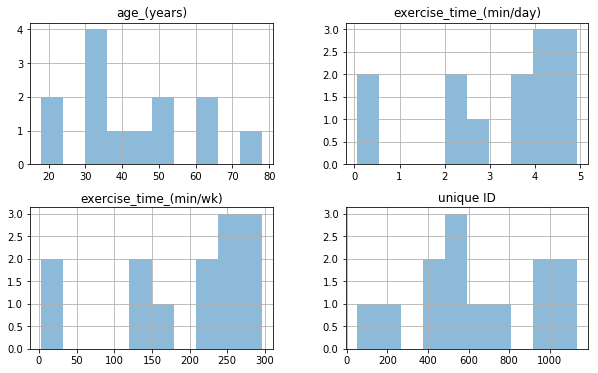

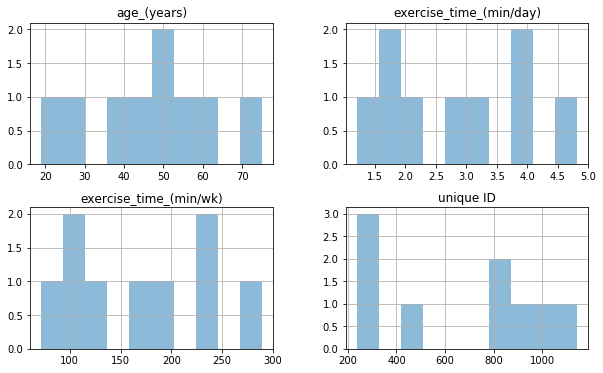

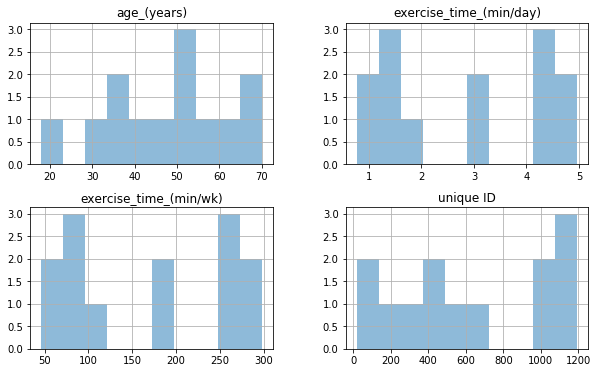

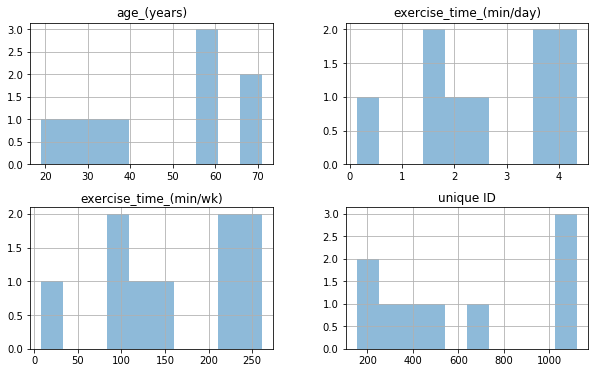

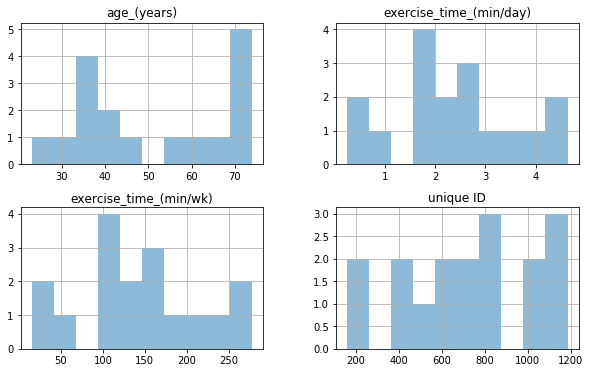

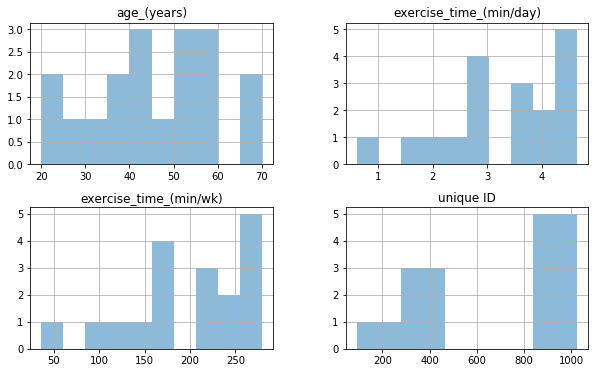

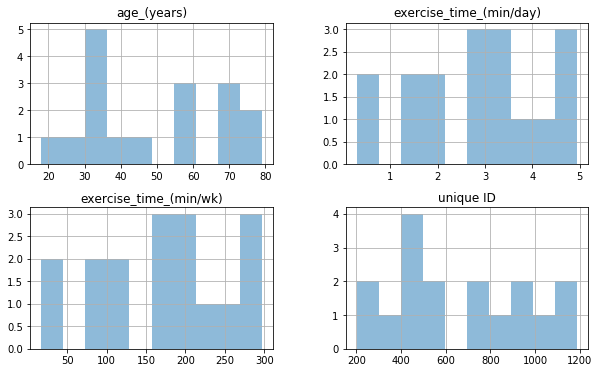

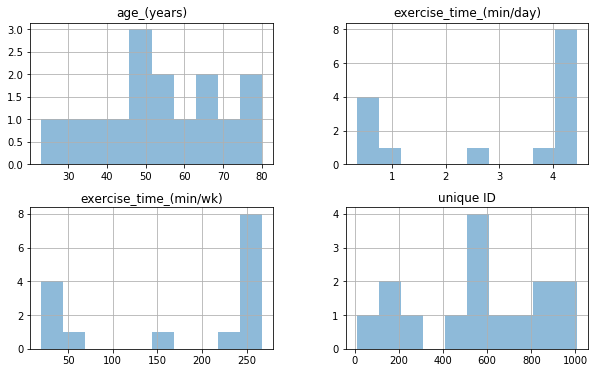

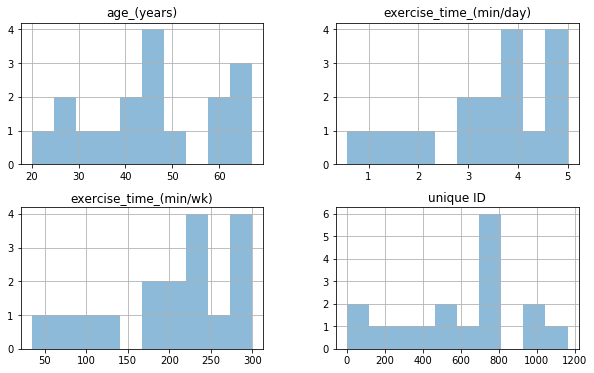

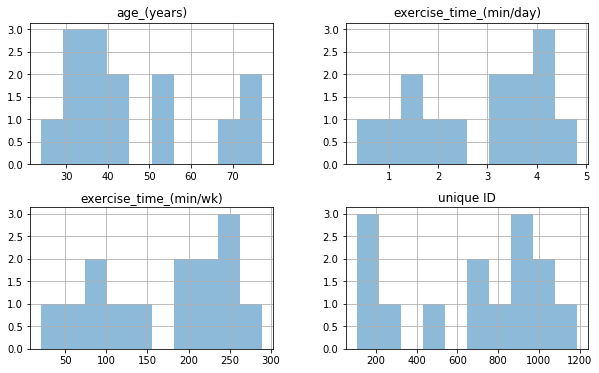

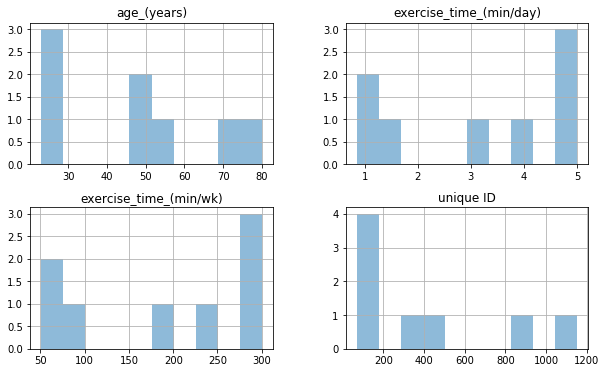

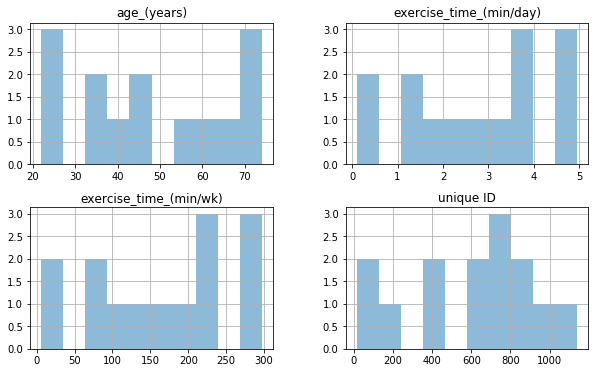

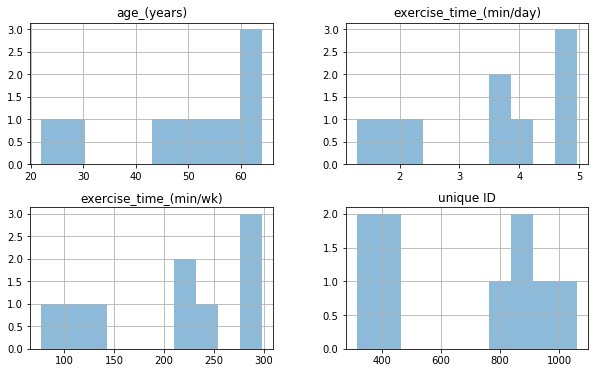

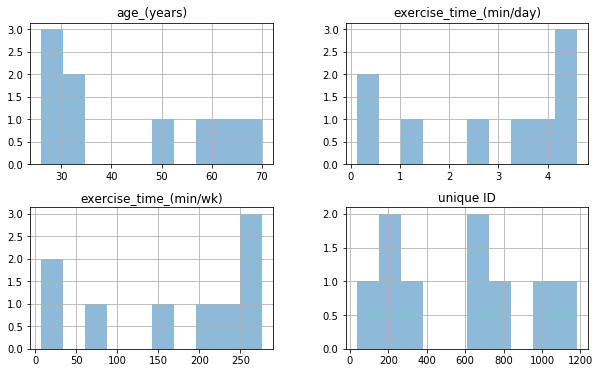

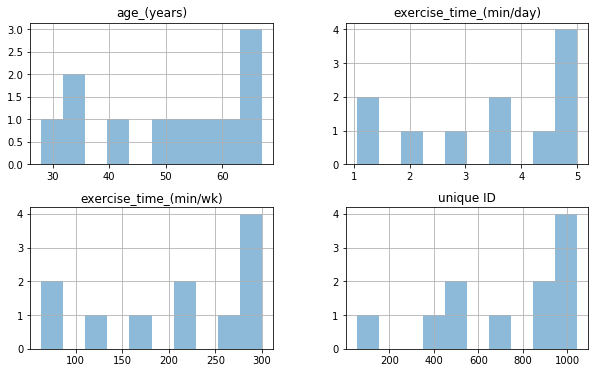

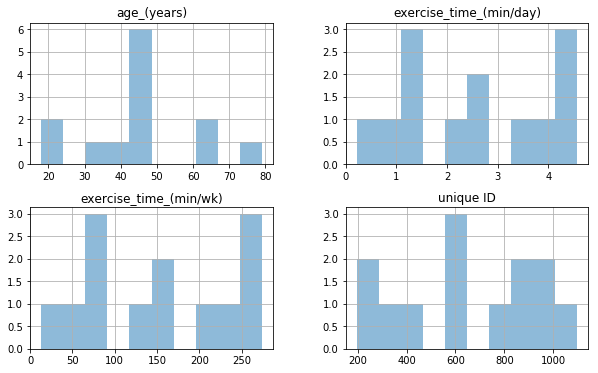

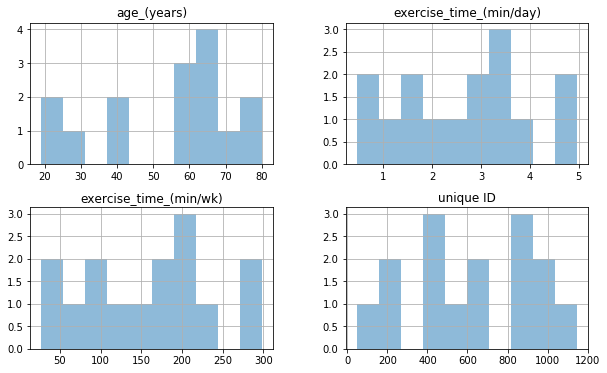

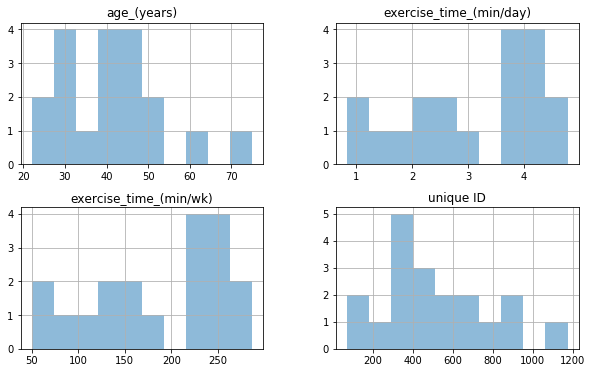

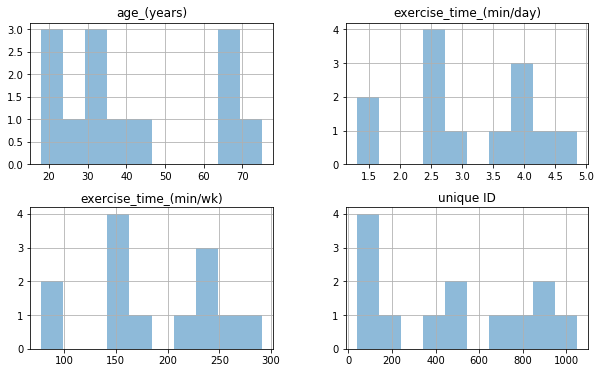

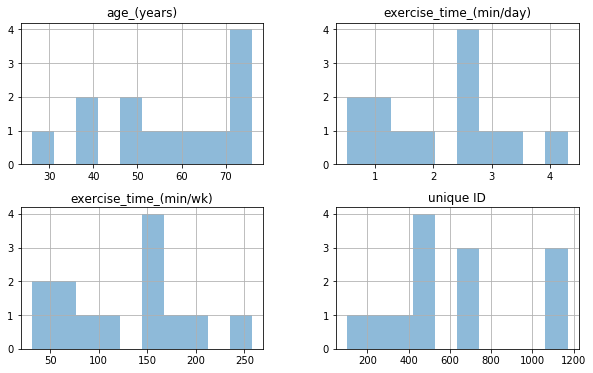

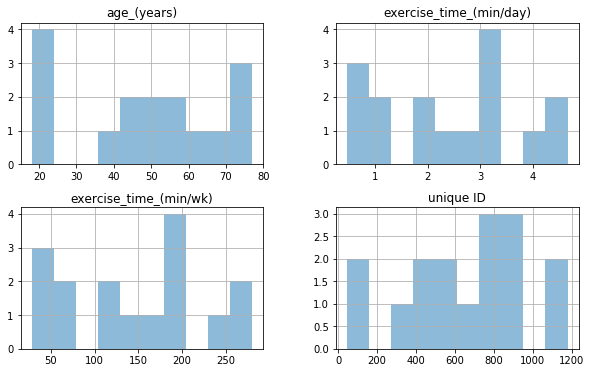

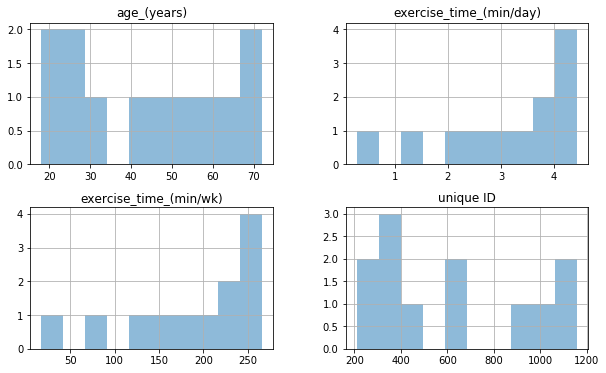

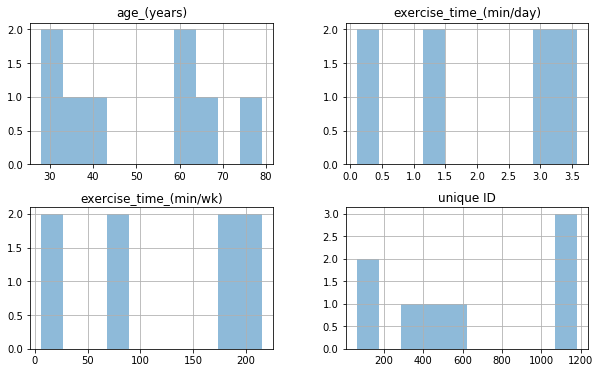

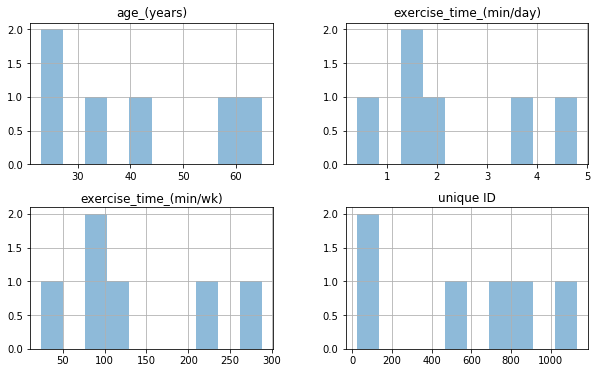

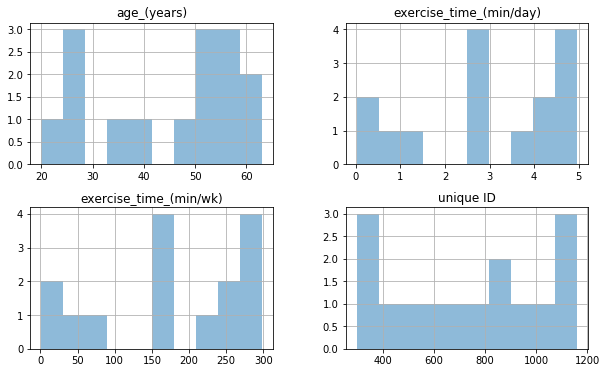

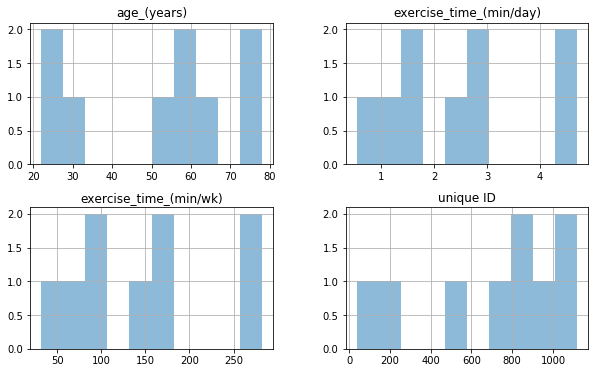

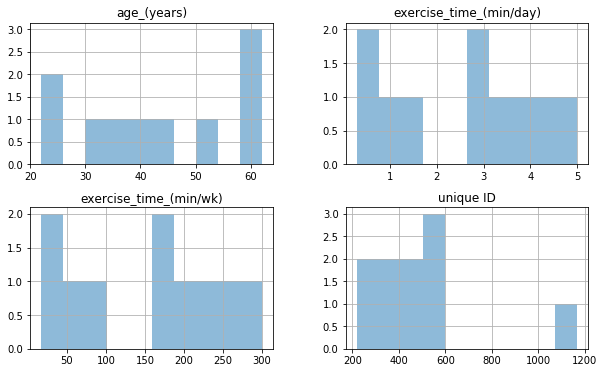

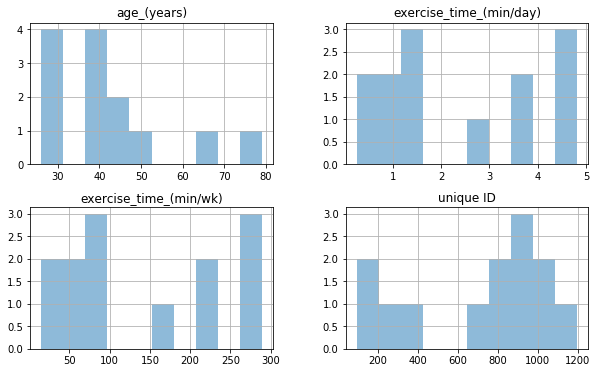

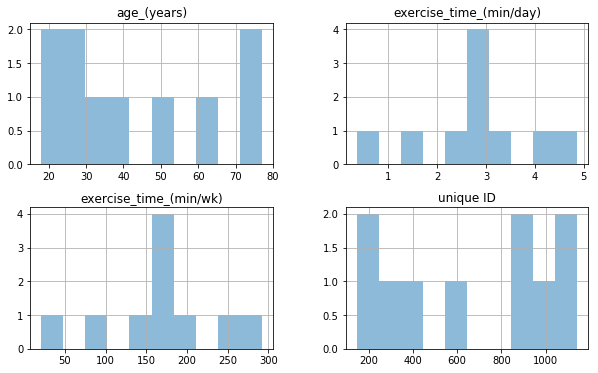

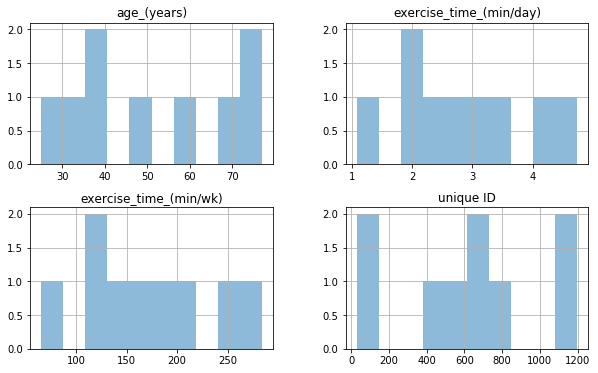

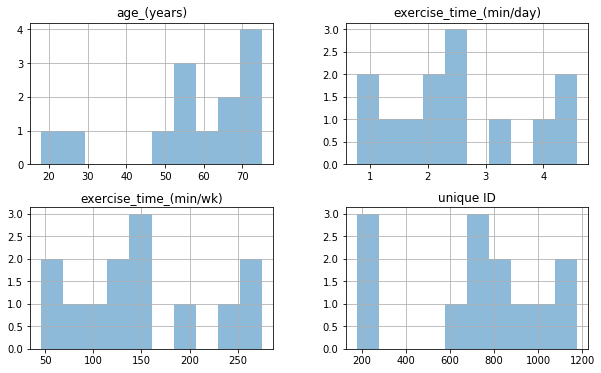

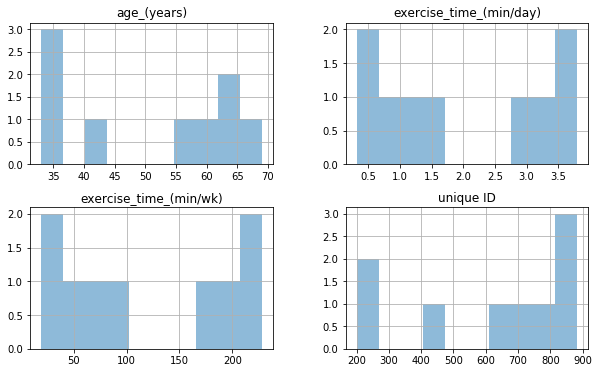

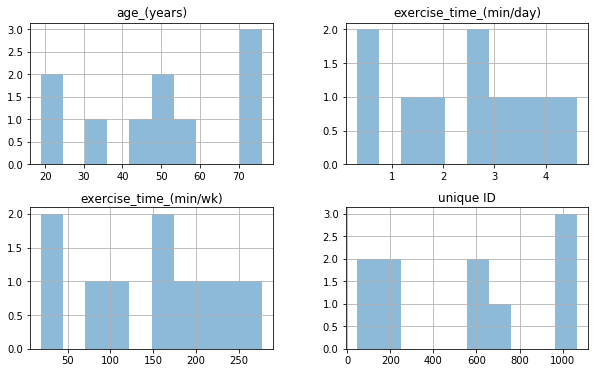

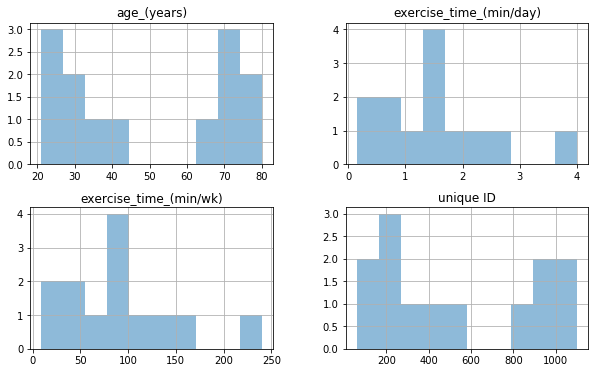

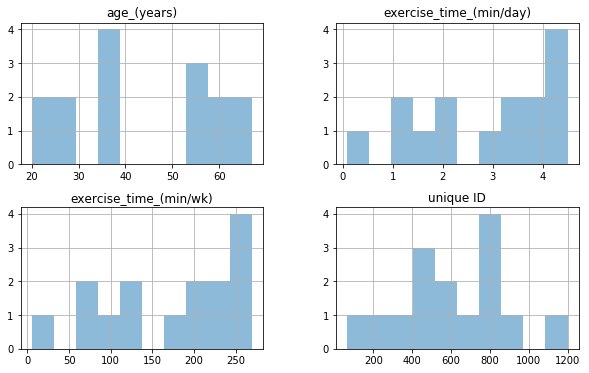

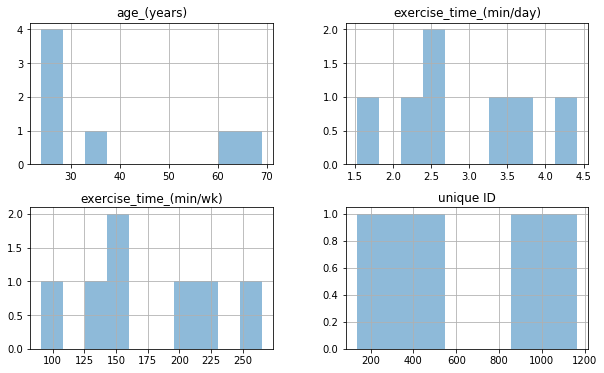

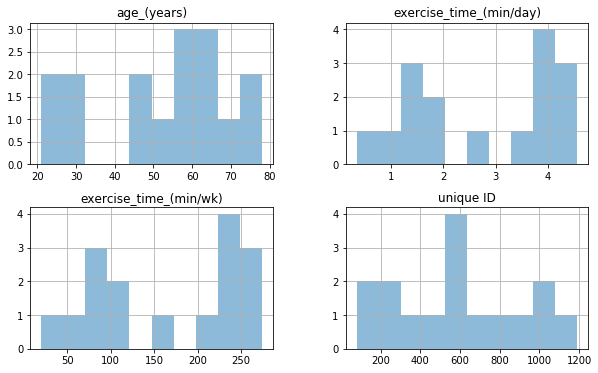

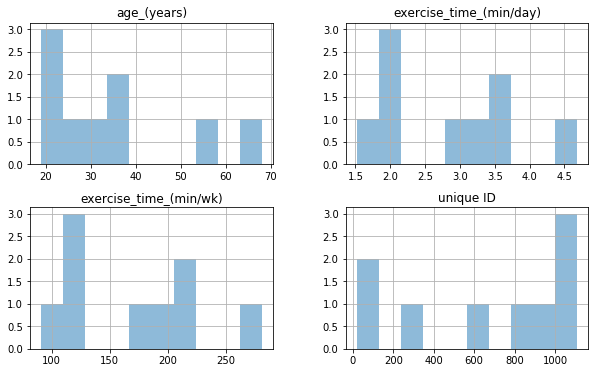

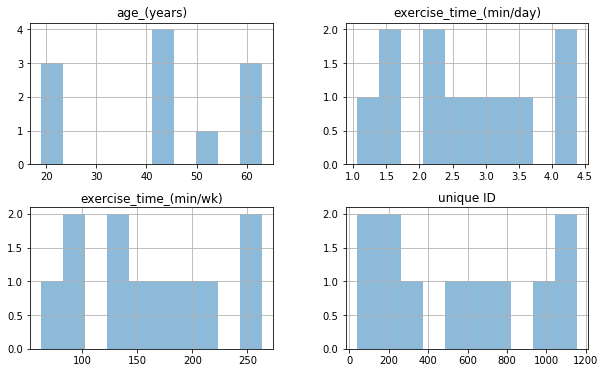

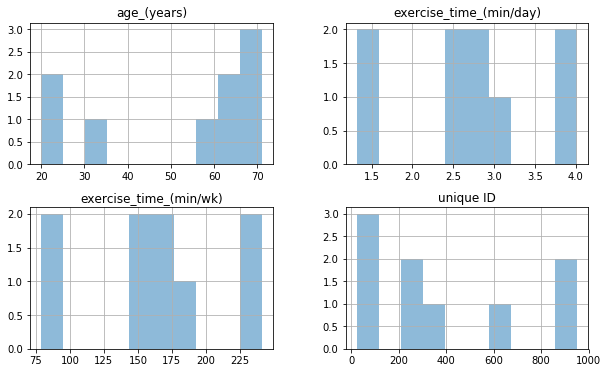

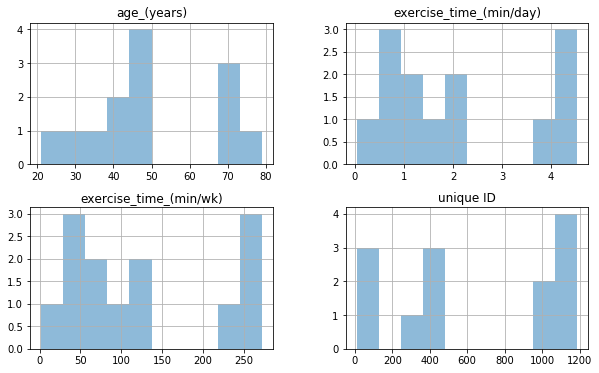

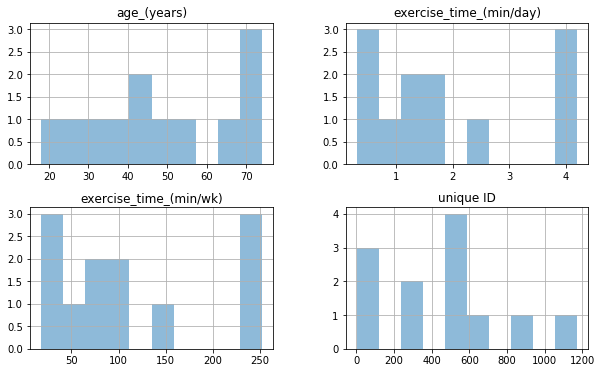

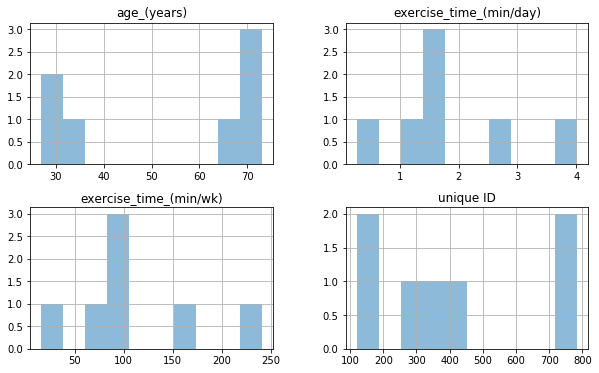

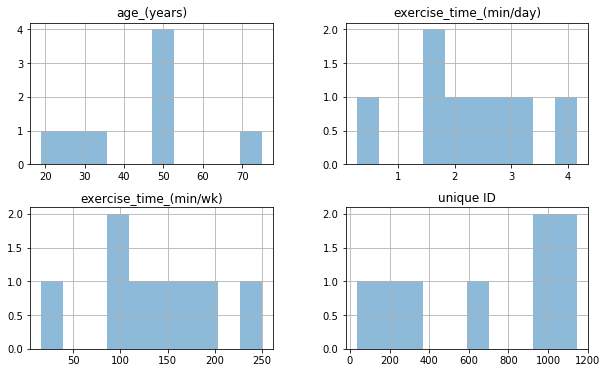

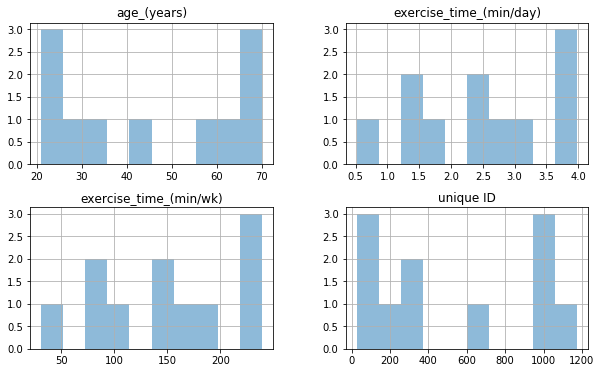

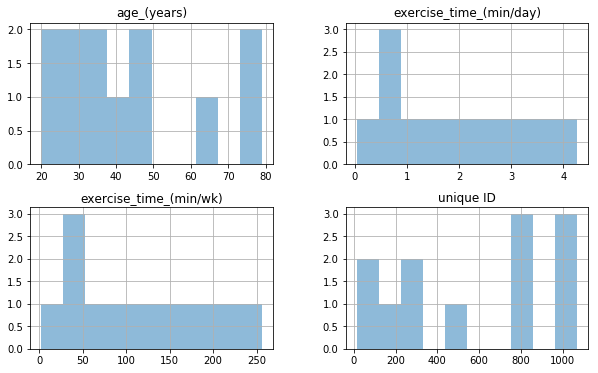

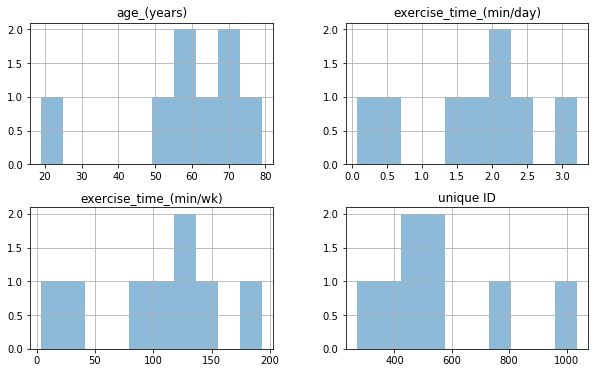

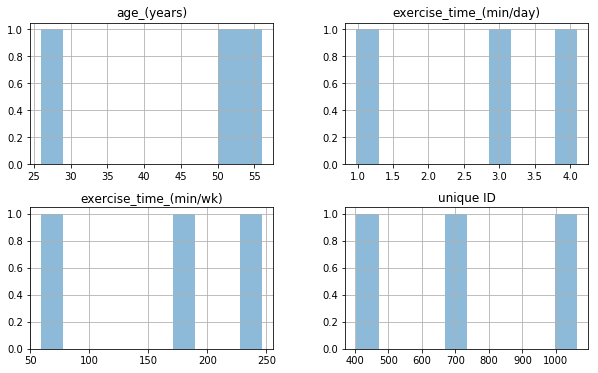

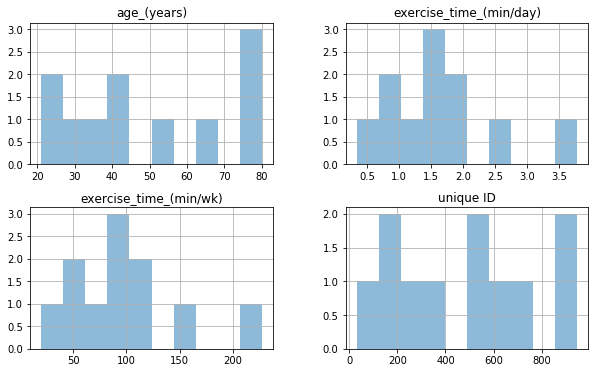

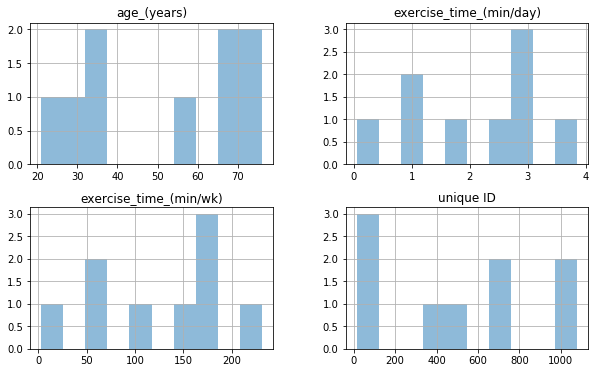

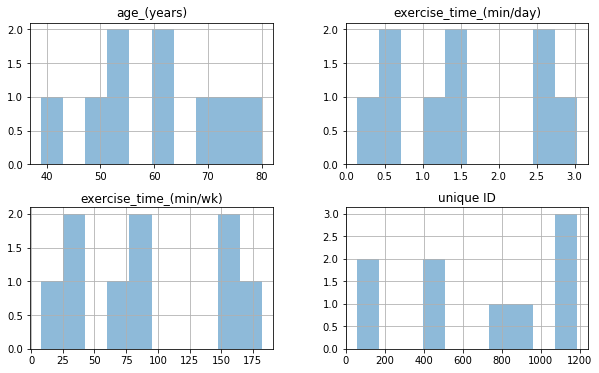

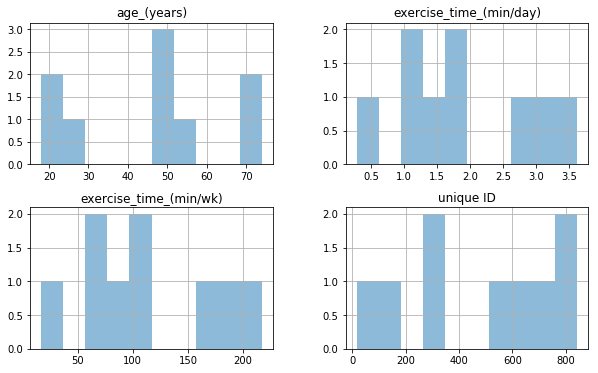

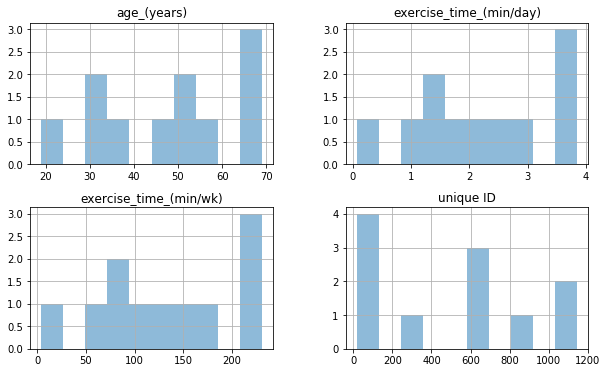

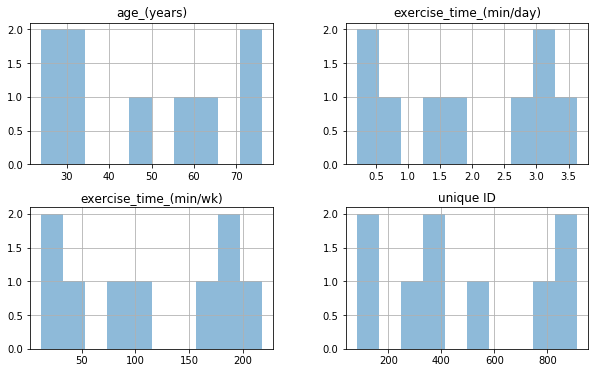

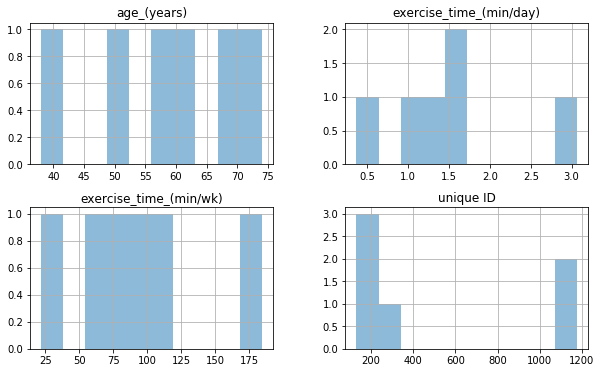

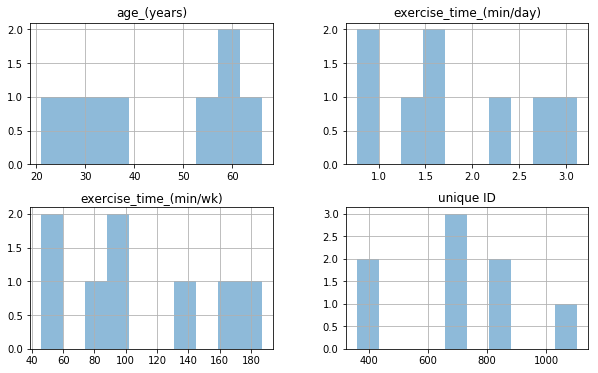

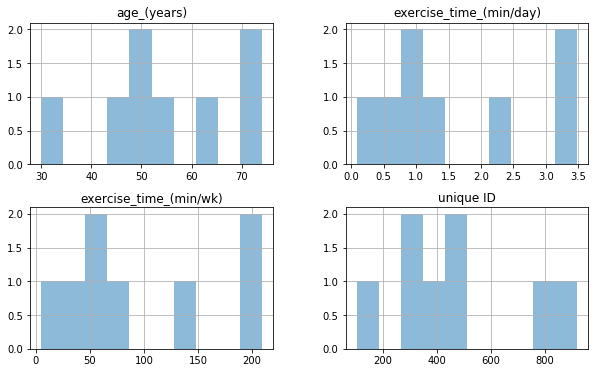

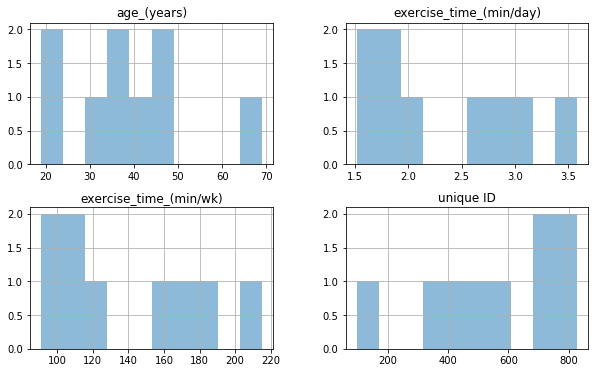

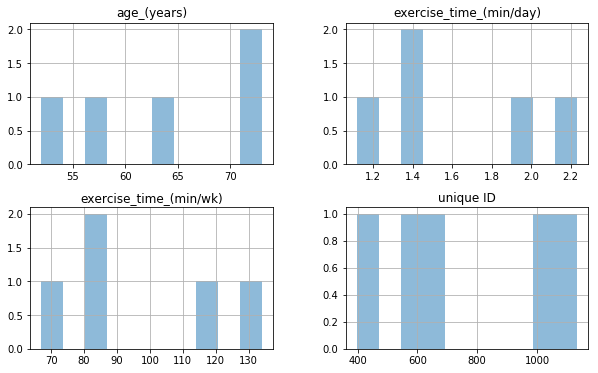

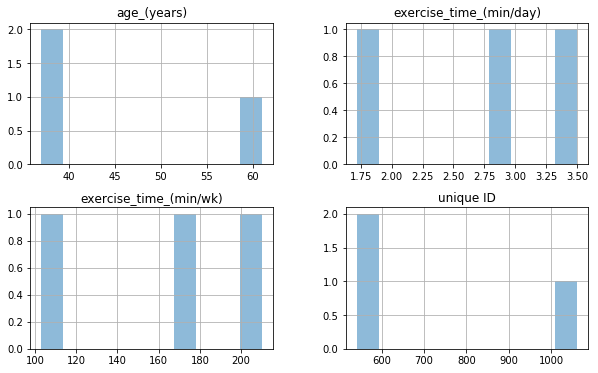

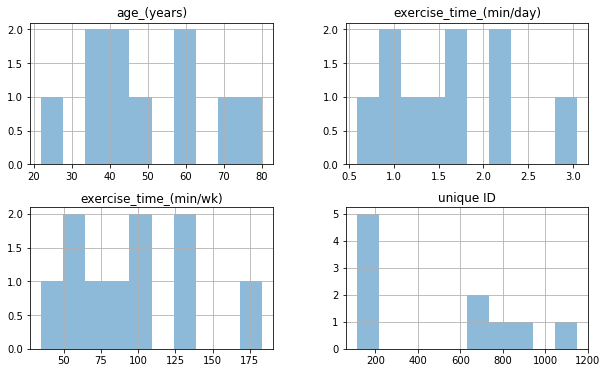

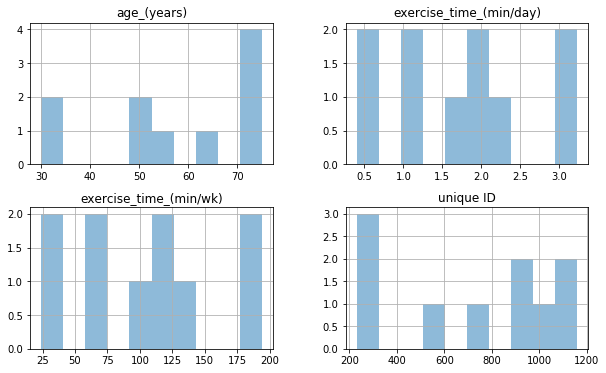

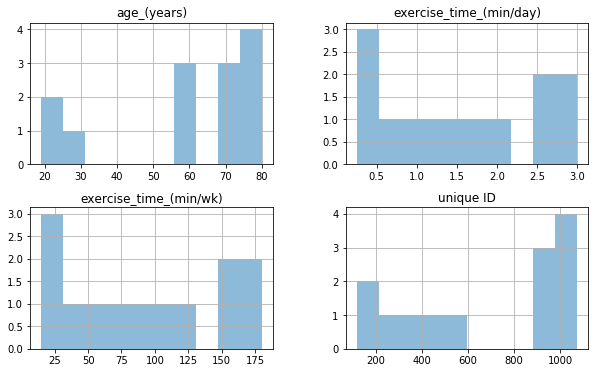

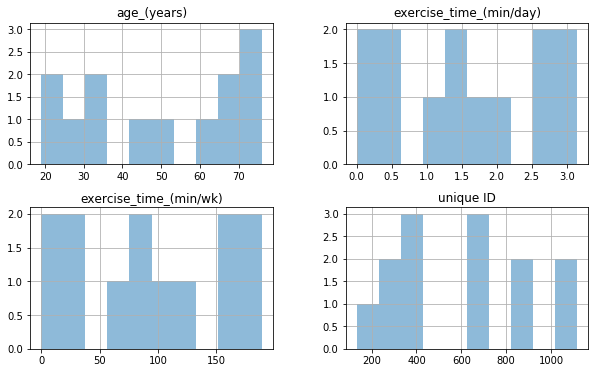

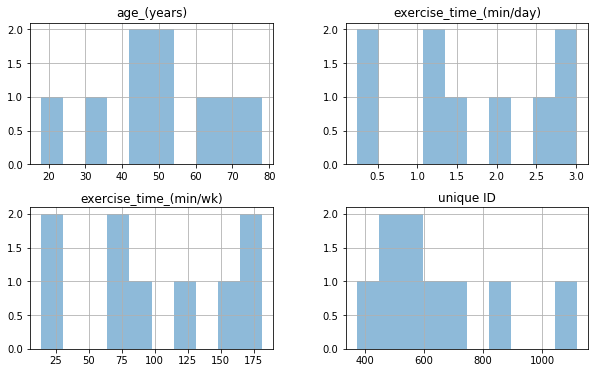

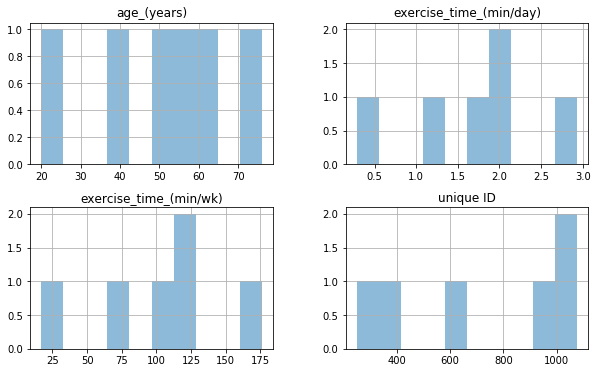

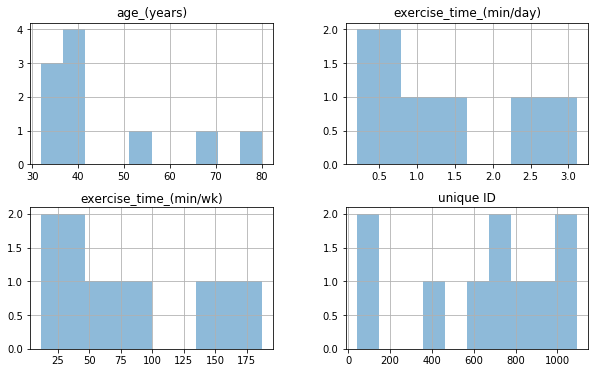

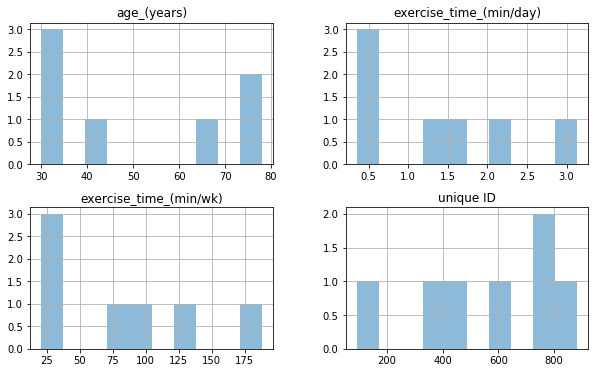

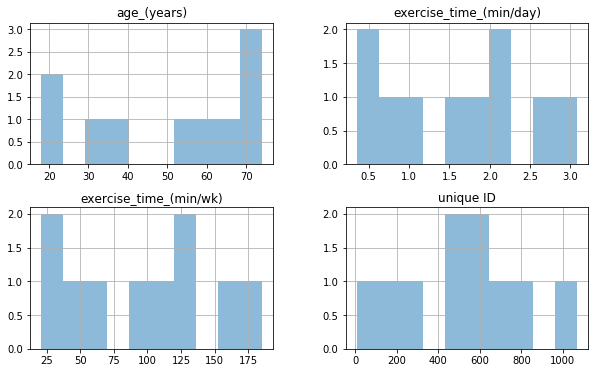

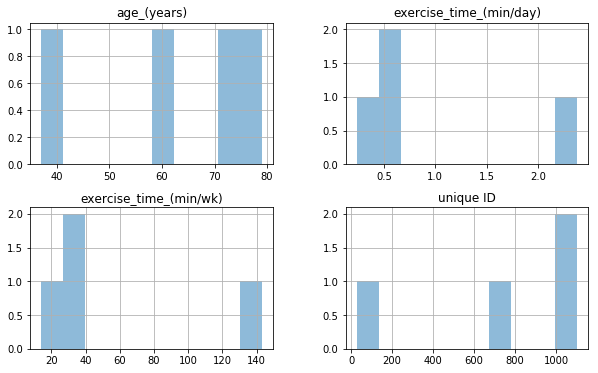

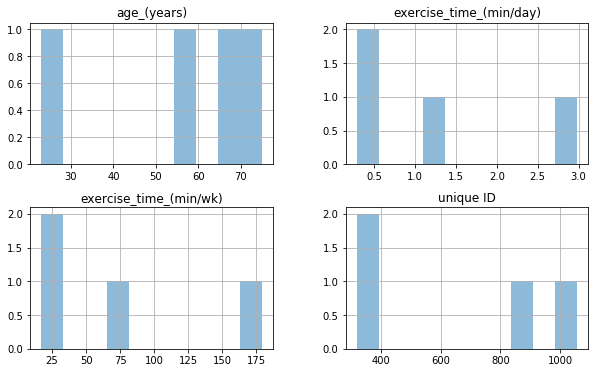

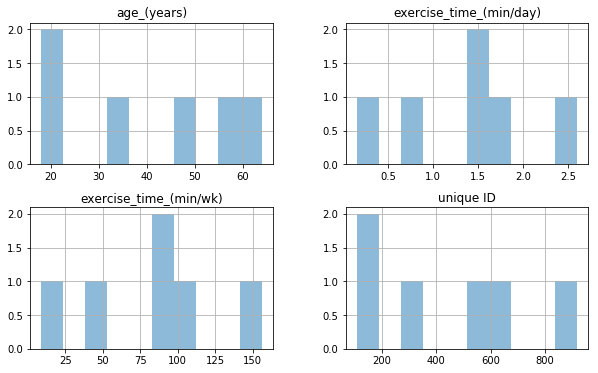

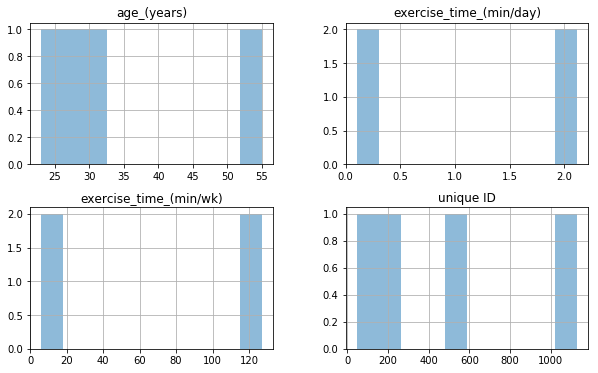

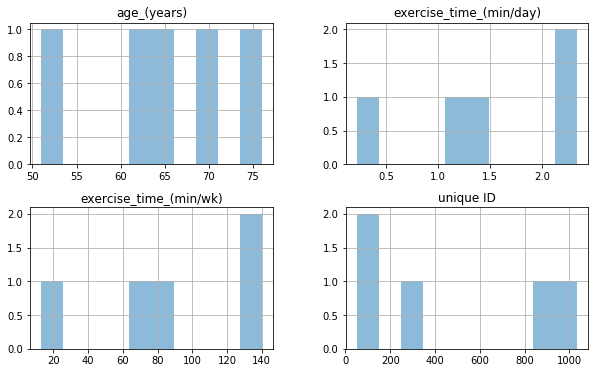

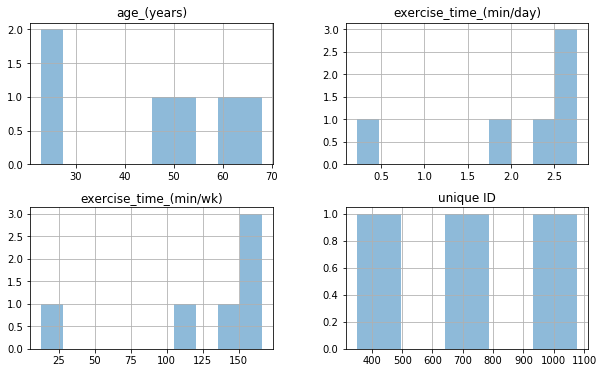

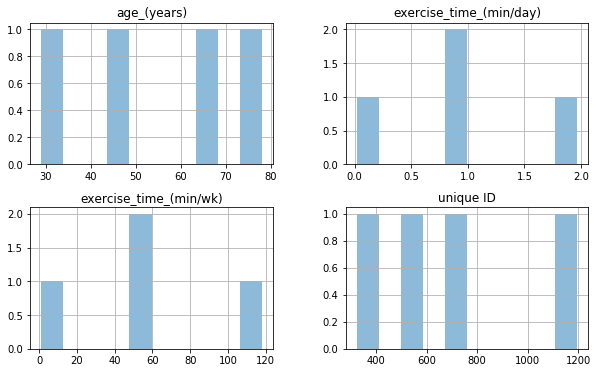

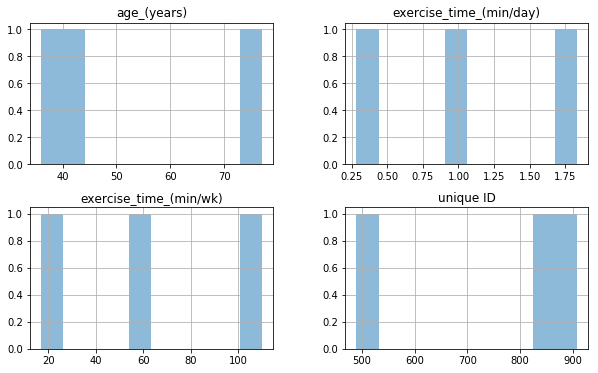

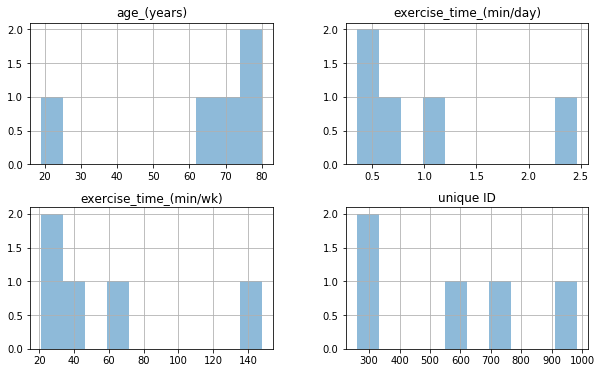

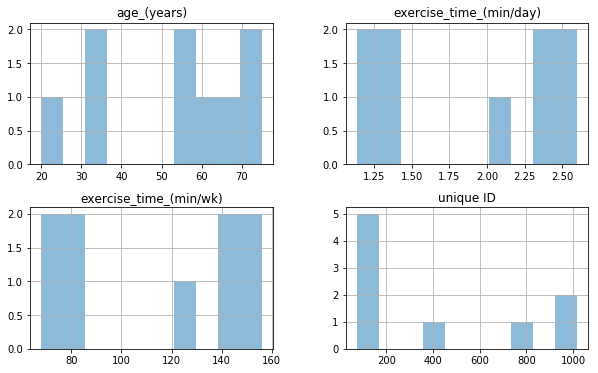

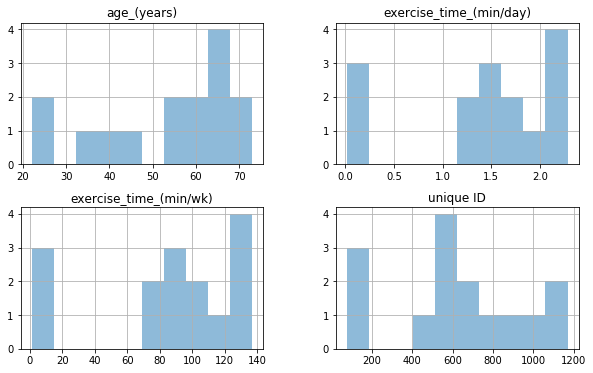

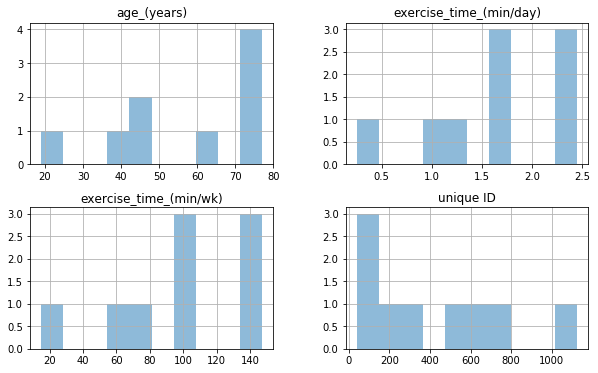

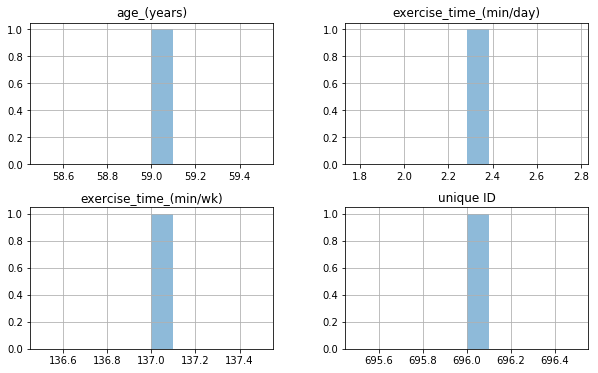

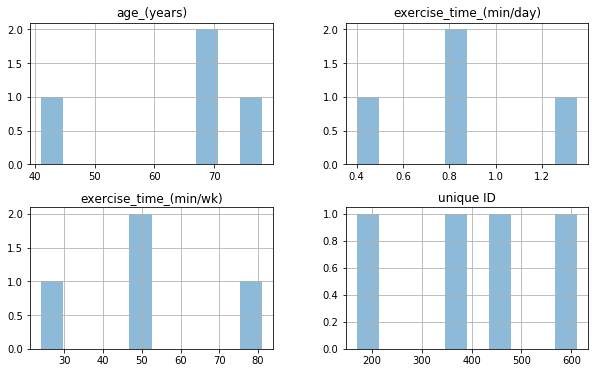

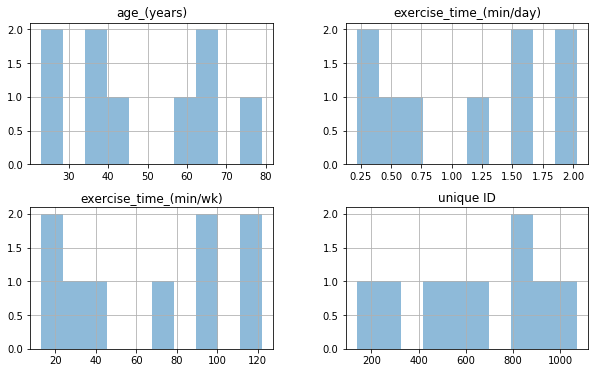

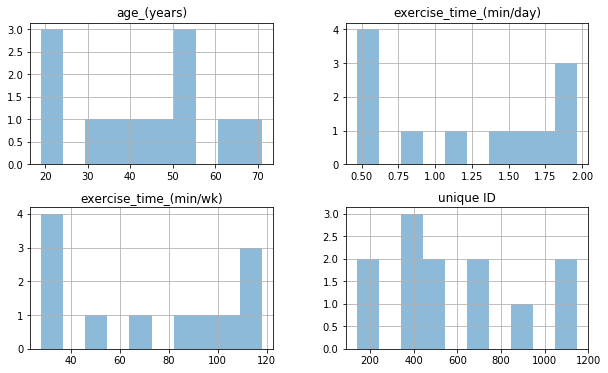

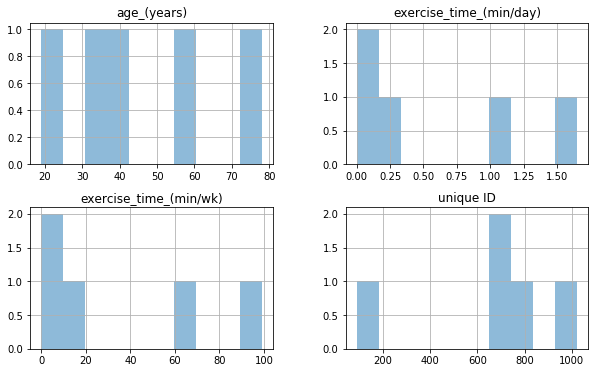

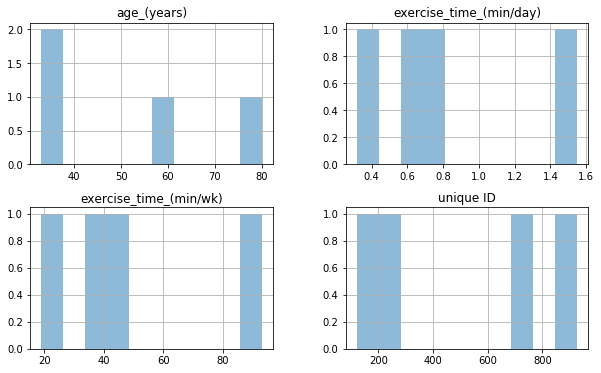

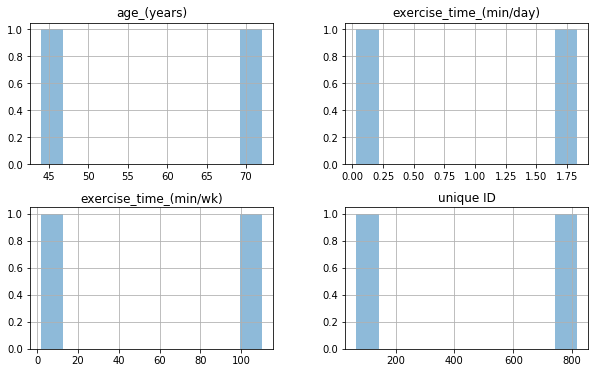

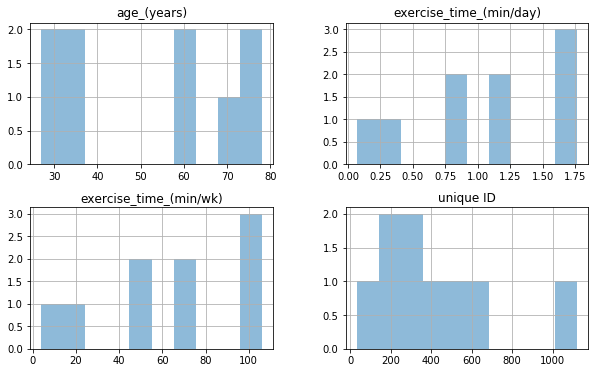

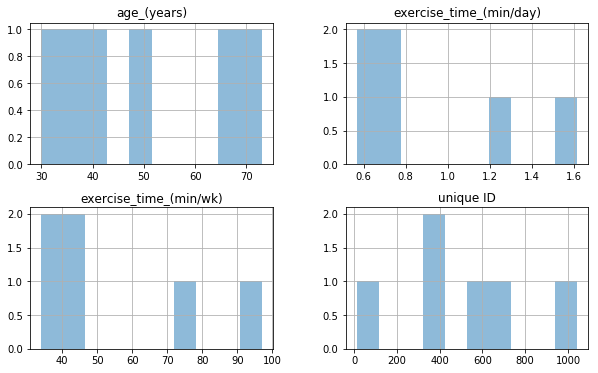

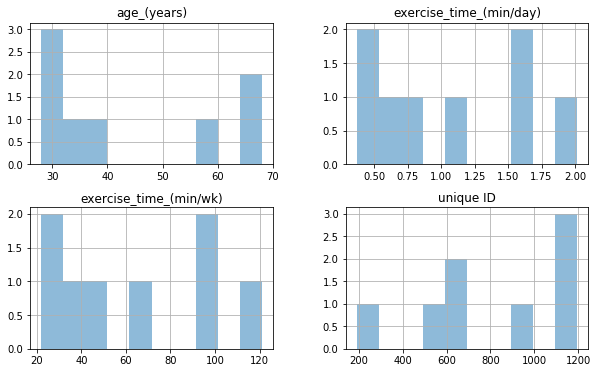

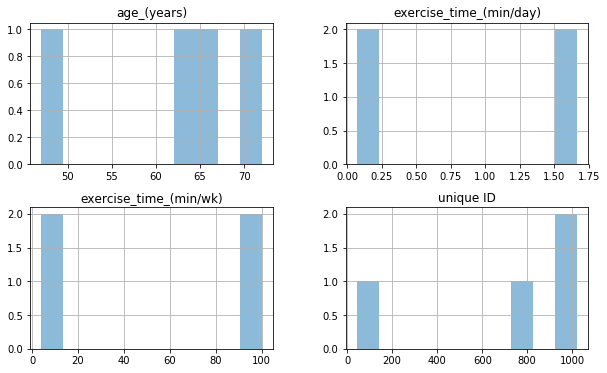

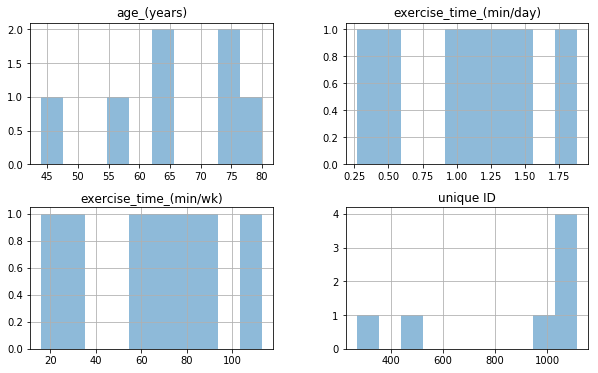

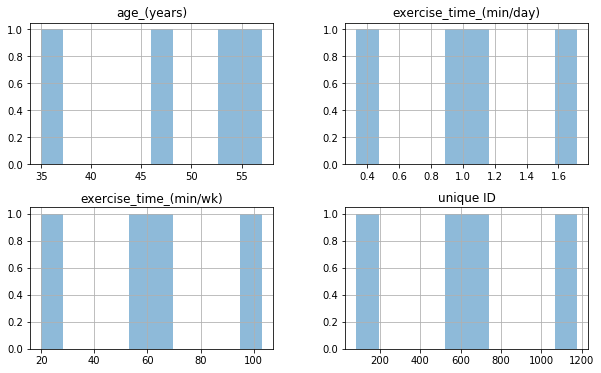

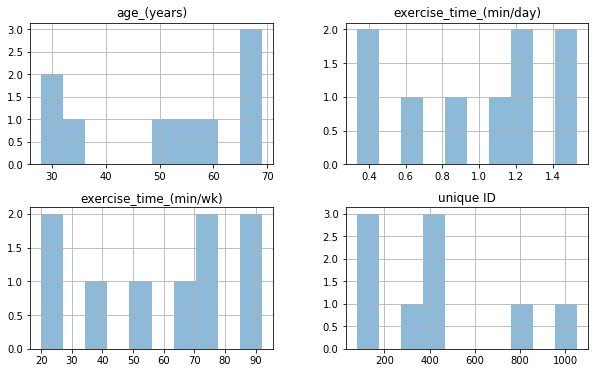

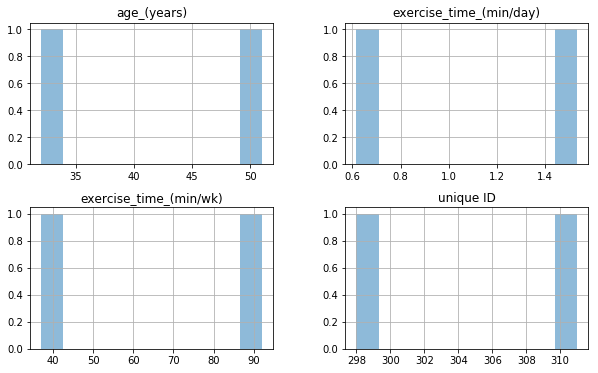

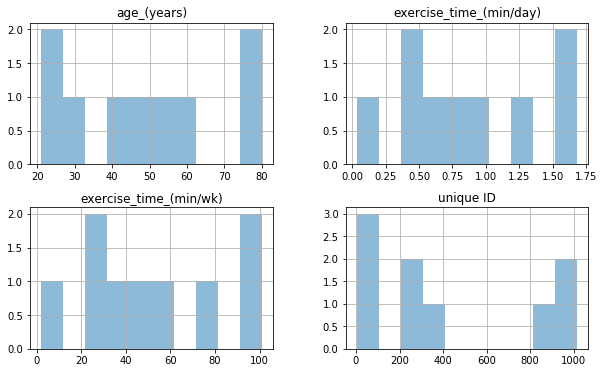

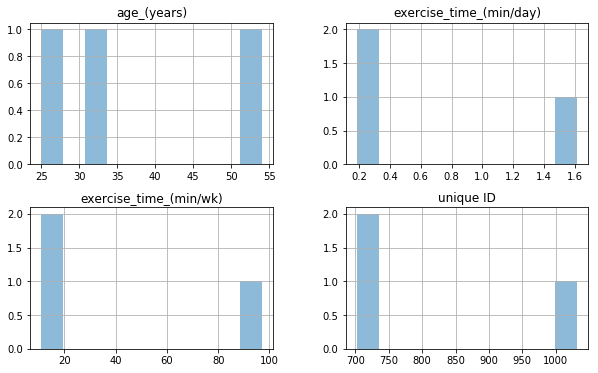

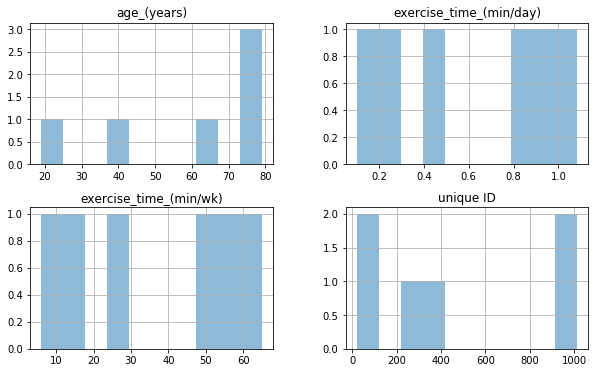

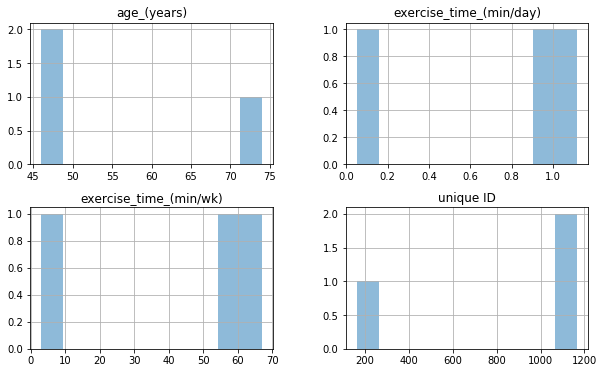

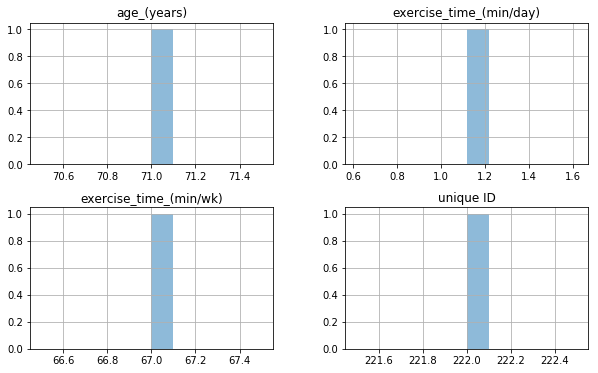

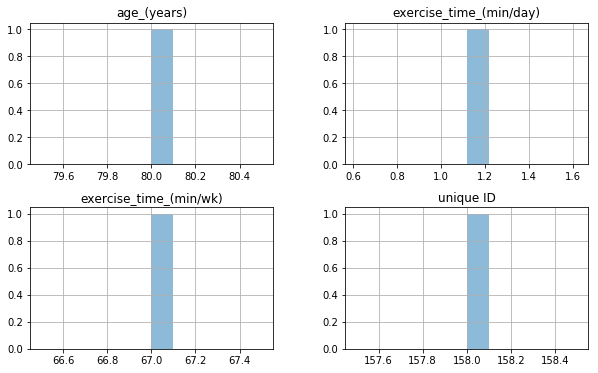

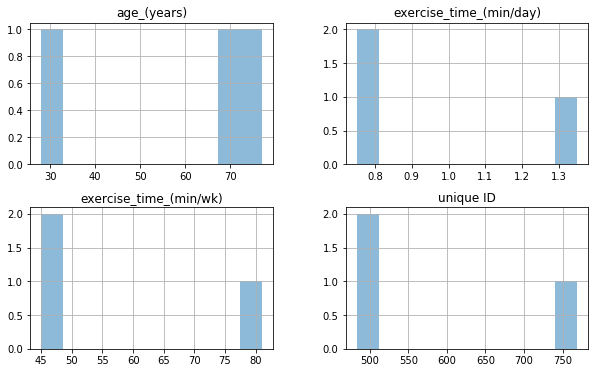

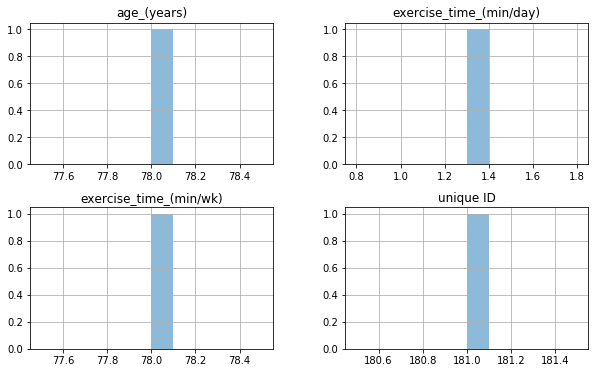

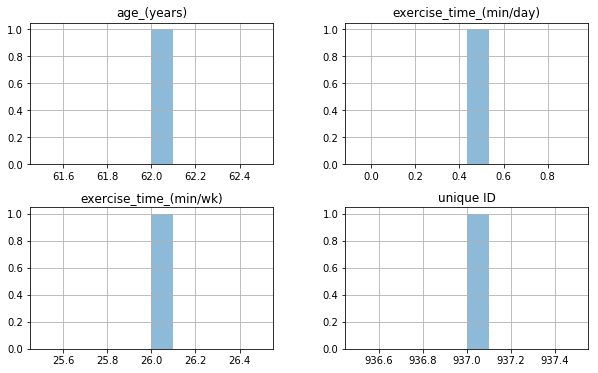

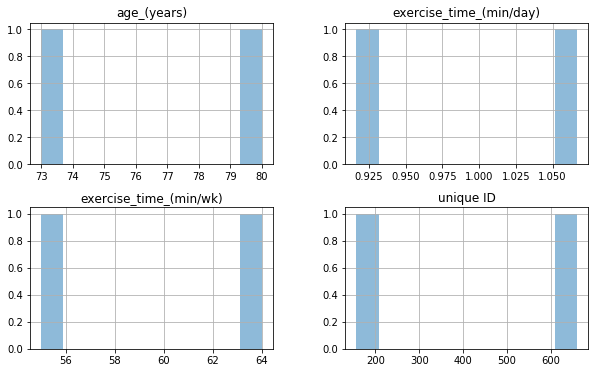

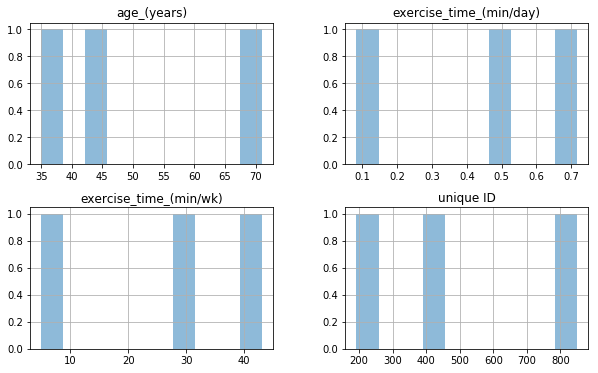

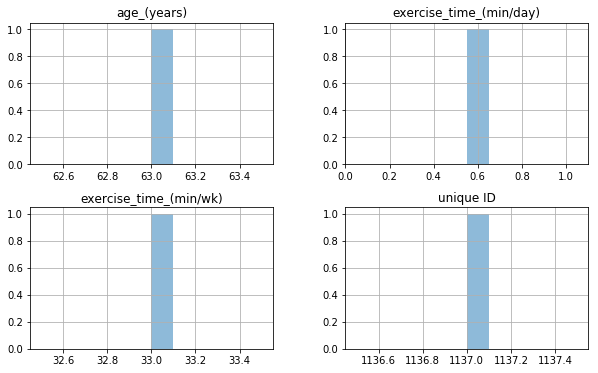

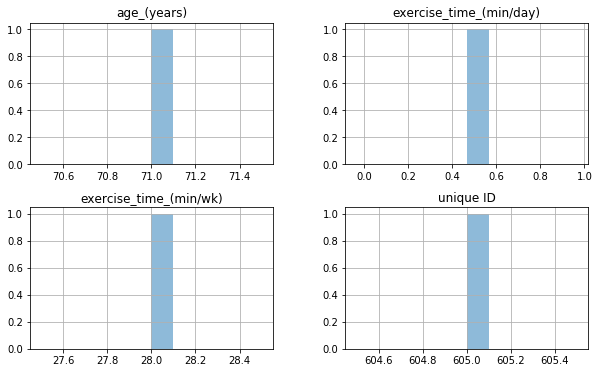

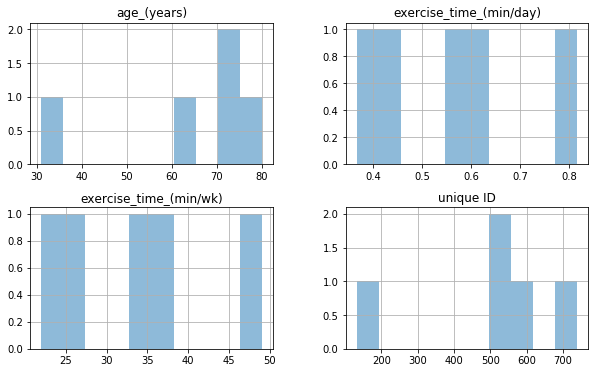

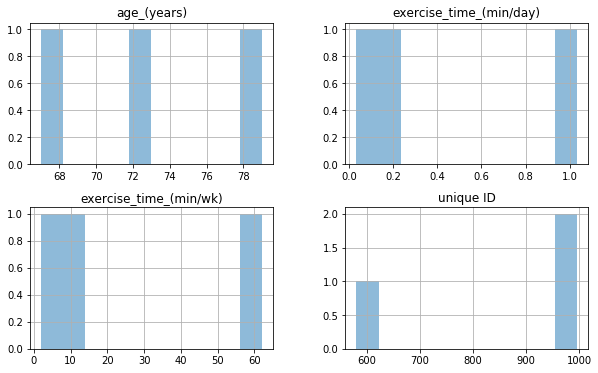

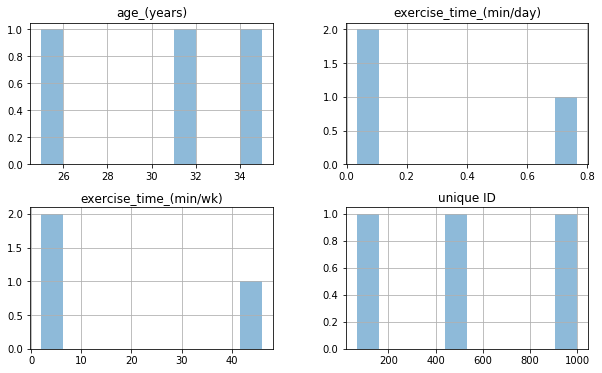

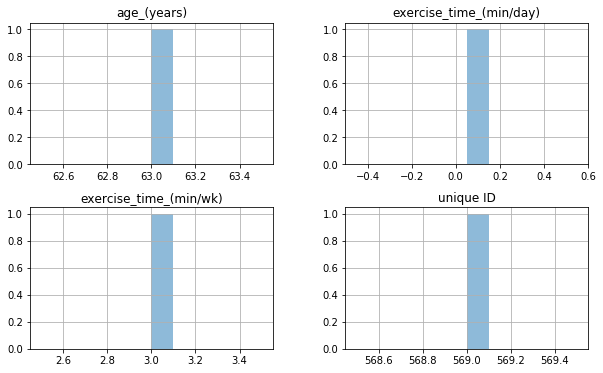

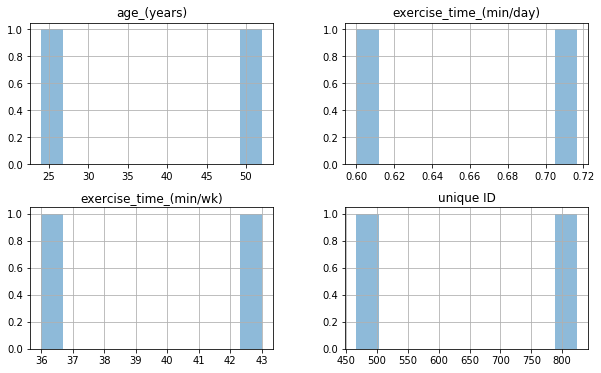

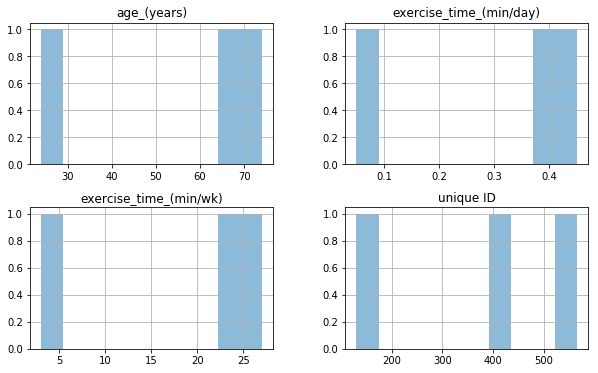

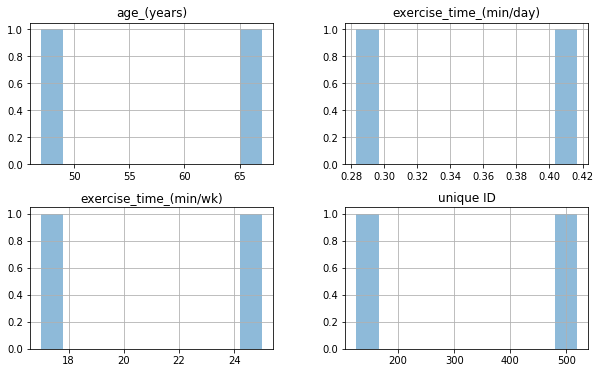

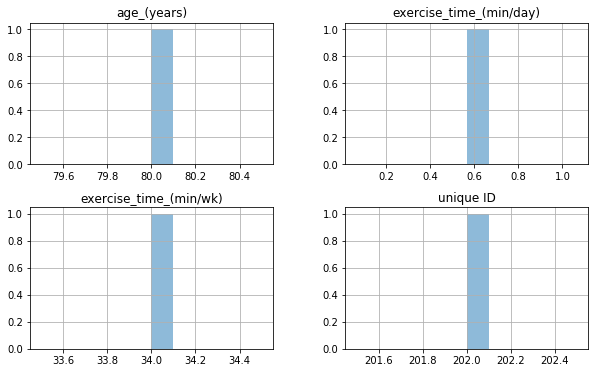

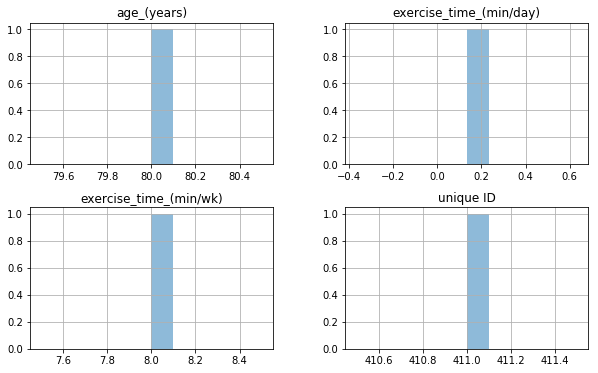

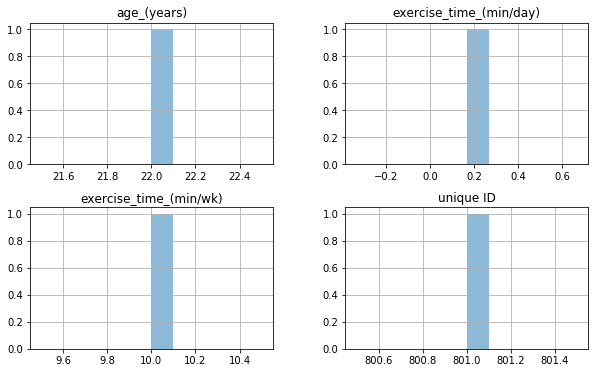

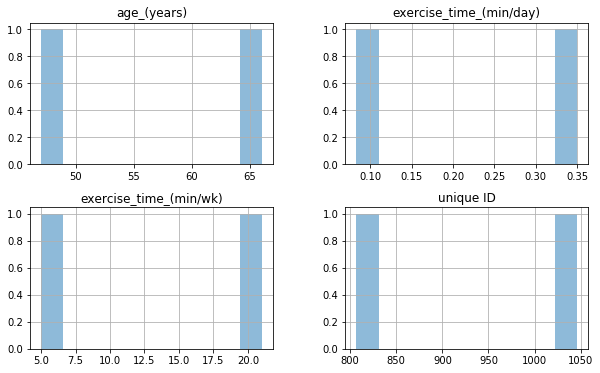

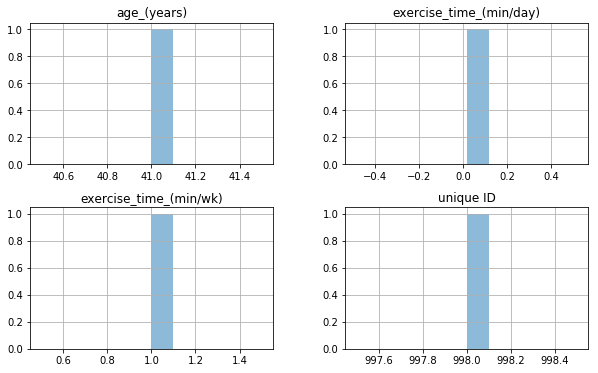

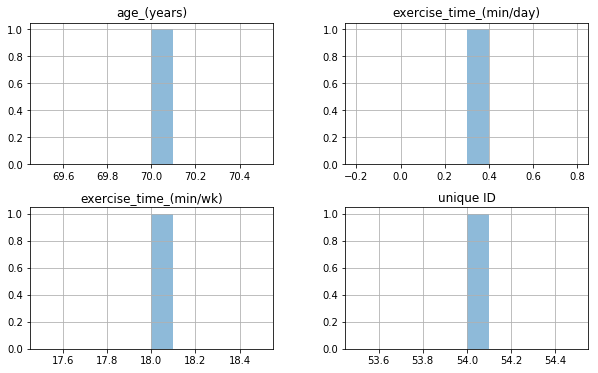

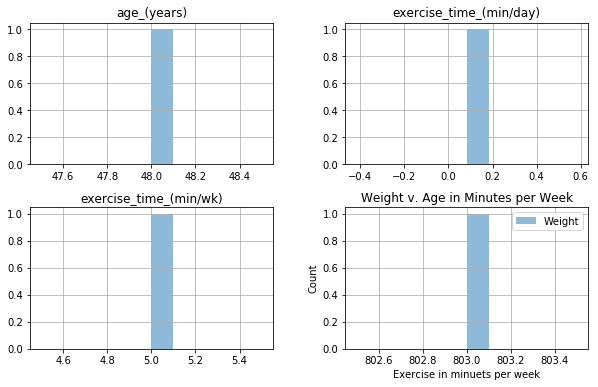

In [52]:
import matplotlib.pyplot as plt

df.groupby("weight_(lbs)").hist(bins=10, alpha=0.5, figsize=(10,6));
plt.title('Weight v. Age in Minutes per Week')
plt.ylabel("Count")
plt.xlabel("Exercise in minuets per week")
plt.legend(["Weight","Age"]);

In [0]:
# Crosstabulating age with exercise time per week
pd.crosstab(df["age_(years)"], df["exercise_time_(min/wk)"]).head()

exercise_time_(min/wk),0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
age_(years),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Crosstabulating weight with exercise time per week
pd.crosstab(df["weight_(lbs)"], df["exercise_time_(min/wk)"]).head()

exercise_time_(min/wk),0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
weight_(lbs),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Crosstabulating age with exercise time per day
pd.crosstab(df["age_(years)"], df["exercise_time_(min/day)"]).head()

exercise_time_(min/day),0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,0.11666666666666667,0.13333333333333333,0.15,0.16666666666666666,0.18333333333333332,0.2,0.21666666666666667,0.23333333333333334,0.25,0.26666666666666666,0.2833333333333333,0.3,0.31666666666666665,0.3333333333333333,0.35,0.36666666666666664,0.38333333333333336,0.4,0.4166666666666667,0.43333333333333335,0.45,0.4666666666666667,0.5,0.5166666666666667,0.5333333333333333,0.55,0.5666666666666667,0.5833333333333334,0.6,0.6166666666666667,0.6333333333333333,0.65,0.6666666666666666,...,4.333333333333333,4.35,4.366666666666666,4.383333333333334,4.4,4.416666666666667,4.433333333333334,4.45,4.466666666666667,4.483333333333333,4.5,4.516666666666667,4.533333333333333,4.55,4.566666666666666,4.583333333333333,4.6,4.616666666666666,4.633333333333334,4.65,4.666666666666667,4.683333333333334,4.7,4.716666666666667,4.733333333333333,4.75,4.766666666666667,4.783333333333333,4.8,4.816666666666666,4.833333333333333,4.85,4.866666666666666,4.883333333333334,4.9,4.933333333333334,4.95,4.966666666666667,4.983333333333333,5.0
age_(years),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Crosstabulating weight with exercise time per day
pd.crosstab(df["weight_(lbs)"], df["exercise_time_(min/day)"]).head()

exercise_time_(min/day),0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,0.11666666666666667,0.13333333333333333,0.15,0.16666666666666666,0.18333333333333332,0.2,0.21666666666666667,0.23333333333333334,0.25,0.26666666666666666,0.2833333333333333,0.3,0.31666666666666665,0.3333333333333333,0.35,0.36666666666666664,0.38333333333333336,0.4,0.4166666666666667,0.43333333333333335,0.45,0.4666666666666667,0.5,0.5166666666666667,0.5333333333333333,0.55,0.5666666666666667,0.5833333333333334,0.6,0.6166666666666667,0.6333333333333333,0.65,0.6666666666666666,...,4.333333333333333,4.35,4.366666666666666,4.383333333333334,4.4,4.416666666666667,4.433333333333334,4.45,4.466666666666667,4.483333333333333,4.5,4.516666666666667,4.533333333333333,4.55,4.566666666666666,4.583333333333333,4.6,4.616666666666666,4.633333333333334,4.65,4.666666666666667,4.683333333333334,4.7,4.716666666666667,4.733333333333333,4.75,4.766666666666667,4.783333333333333,4.8,4.816666666666666,4.833333333333333,4.85,4.866666666666666,4.883333333333334,4.9,4.933333333333334,4.95,4.966666666666667,4.983333333333333,5.0
weight_(lbs),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
pd.crosstab(df['age_(years)'], df['exercise_time_(min/wk)'], normalize='columns')

exercise_time_(min/wk),0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
age_(years),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,...,0.000000,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
19,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,...,0.000000,0.00,0.25,0.00,0.00,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
20,0.5,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.00,...,0.000000,0.00,0.00,0.00,0.00,0.0,0.000000,0.25,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.5,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.00,0.00,0.000000,0.0,0.0
21,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.0,0.0,0.00,...,0.000000,0.00,0.00,0.00,0.00,0.2,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
22,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,...,0.000000,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
23,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.166667,0.142857,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,...,0.000000,0.00,0.00,0.00,0.25,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
24,0.0,0.00,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.0,0.0,0.00,...,0.000000,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
      - There are both discrete and continous vairables, along with some confounding variables.
2.  What are the relationships between the variables?
        - The age along with weight tend to have a correlation. Also the weight and exercise tend to have a correlation.
3.  Which relationships are "real", and which spurious?
      - The relationships that are real are the weight to exercise, age to exercise, and the spurious ones are the weight to age.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)